In [1]:
#!pip install gdown
#!pip install --upgrade gdown
#gdown "<file_ID>&confirm=t"
#!gdown https://drive.google.com/drive/u/2/folders/1UcGBLqbF66lqhqf15vmFpoMaQacIMXg1 -O /notebooks/input --folder

  Attempting uninstall: gdown
    Found existing installation: gdown 4.5.1
    Uninstalling gdown-4.5.1:
      Successfully uninstalled gdown-4.5.1
Retrieving folder contents
Processing file 1fotl024ewuBD2Xt_qiTW5tJ-1KbtVNGE x-60.npy
Processing file 1VDFcCKyJYKo1LQz22aJq-J9fkJyc8T9E y-60.npy
Processing file 1zvBl0mo04pO0b0xWp5PXMfcrVJNK5DP2 z-60.npy
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1fotl024ewuBD2Xt_qiTW5tJ-1KbtVNGE
To: /notebooks/input/x-60.npy
100%|███████████████████████████████████████| 45.5M/45.5M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VDFcCKyJYKo1LQz22aJq-J9fkJyc8T9E
To: /notebooks/input/y-60.npy
100%|████████████████████████████████████████| 253k/253k [00:00<00:00, 16.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zvBl0mo04pO0b0xWp5PXMfcrVJNK5DP2
To: /notebooks/input/z-60.npy
100%|████████████████████████████

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LayerNormalization, RepeatVector, Bidirectional, InputLayer, Conv1D, MaxPool1D, Conv2D, Conv3D, MaxPooling3D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, GlobalAveragePooling2D, TimeDistributed, GRU, Dense, LSTM, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Nadam, Adagrad
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit, KFold, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
import matplotlib.pyplot as plt
import statistics
from sklearn import metrics
import glob
import numpy as np
import pandas as pd
from keras import backend as K
print(tf.config.list_physical_devices('GPU'))
if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


In [2]:
class_labels = ['Non-Func','Func']
nbframes = 10
keypoints = 18

In [4]:
def create_data(X, Y, Z):
    final_feature = np.empty((0,duration,3))
    classes = []
    file = []
    count = 0
    feature = np.empty((0,3))
    y_check = []
    length = len(Y)
    
    for i in range(0, length//duration*duration):
        row = X.iloc[i].values
        row_reshaped = np.reshape(row, (1, 3))
        feature = np.vstack((feature, row_reshaped))
        y_check.append(Y.iloc[i])
        if feature.shape[0] == duration:
            y_check = np.array(y_check)
            
            #all_equal_to_0 = np.all(y_check == 0)
            all_equal_to_1 = np.all(y_check == 1)
            all_equal_to_2 = np.all(y_check == 2)
            #all_equal_to_1 = np.count_nonzero(y_check == 1) / len(y_check)
            #all_equal_to_2 = np.count_nonzero(y_check == 2) / len(y_check)
            
            if all_equal_to_1:
                final_feature = np.append(final_feature, [feature], axis=0)
                classes.append(0)
                file.append(Z)
            elif all_equal_to_2: #Functional
                final_feature = np.append(final_feature, [feature], axis=0)
                classes.append(1)
                file.append(Z)
            #elif all_equal_to_0:
            #    final_feature = np.append(final_feature, [feature], axis=0)
            #    classes.append(0)
            feature = np.empty((0,3))
            y_check = []
    classes = np.array(classes)
    return final_feature, classes, file

In [3]:
def build_lstm(shape=(10, 18)):
    
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape=shape))
    model.add(LSTM(128, return_sequences = False))
    #model.add(GRU(64, return_sequences = False))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [4]:
def build_GRU(shape=(10, 18)):
    
    model = Sequential()
    model.add(GRU(128, return_sequences = True, input_shape=shape))
    model.add(GRU(128, return_sequences = False))
    #model.add(GRU(64, return_sequences = False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
def mlp(shape=(180,)):
    model = Sequential()
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [6]:
# Confusion matrix
def cm(X, Y, model):
    
    #model = tf.keras.models.load_model(model_path, custom_objects={'leaky_relu': tf.nn.leaky_relu})
    y_pred = model.predict(X)
    #y_pred = y_pred.round()
    y_pred = np.round(y_pred).tolist()
    print(len(Y[Y==0]), len(Y[Y==1]), len(y_pred))
    if (len(Y[Y==0])/len(Y) != 0) and (len(Y[Y==0])/len(Y) != 1):
        cm = confusion_matrix(Y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()
        
        #Classification report
        print('Classification Report')
        print(classification_report(Y, y_pred, target_names = class_labels))

In [7]:
def recall_m(y_true, y_pred): # TPR
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # P
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # TP + FP
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n

In [11]:
def create_model(X, Y, Z):
    
    fullshape = (nbframes, keypoints)
    print(fullshape)
    
    train_accuracies = np.array([])
    val_accuracies = np.array([])
    
    sf = GroupKFold(n_splits=22)
    for train_index, val_index in sf.split(X, Y, Z):
        opt = RMSprop(learning_rate = 1e-3)
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = Y[train_index], Y[val_index]
        z_train, z_val = Z[train_index], Z[val_index]
        print("Z train: ",np.unique(z_train))
        print("Z val: ", np.unique(z_val))
        
        #if np.unique(z_val) not in [114, 104, 132, 119, 140, 116, 139, 129, 211, 214, 216, 217]:
        
        print('Train: ',len(y_train[y_train==0]),len(y_train[y_train==1]))

        print('Val: ',len(y_val[y_val==0]),len(y_val[y_val==1]))


        class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
        print("class weights: ", class_weights)
        class_weights = dict(zip(np.unique(y_train), class_weights))

        modelts = build_lstm(fullshape)
        #modelts = build_cnnlstm()
        modelts.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['binary_accuracy', f1_m],
                    sample_weight_mode="temporal"
            )
        #modelts = mlp(60, )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',  # Metric to monitor for improvement
            factor=0.1,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
            patience=100,           # Number of epochs with no improvement after which learning rate will be reduced
            verbose=1,            # Verbosity mode (0: silent, 1: update messages)
            min_lr=1e-9         # Lower bound on the learning rate
        )

        monitor = EarlyStopping(monitor = 'val_loss', 
                                #min_delta=1e-4, 
                                verbose = 0, patience = 100, mode = 'auto', restore_best_weights = True)
        history = modelts.fit(x_train, y_train, validation_data=(x_val,y_val), verbose=2, 
                              shuffle = False,
                            callbacks = [reduce_lr, monitor], 
                            epochs=5000, batch_size= 64,
                            #class_weight=class_weights
                           )

        train_accuracy = modelts.evaluate(x_train, y_train, verbose=2)
        train_accuracies = np.append(train_accuracies, train_accuracy[1])

        val_accuracy = modelts.evaluate(x_val, y_val, verbose=2)
        val_accuracies = np.append(val_accuracies, val_accuracy[1])

        print("Subject: ", np.unique(z_val))
        print('Confusion Matrix for Training')
        cm(x_train, y_train, modelts)
        print('Confusion Matrix for Validation')
        cm(x_val, y_val, modelts)

        plt.plot(history.history['binary_accuracy'], label = 'Training accuracy')
        plt.plot(history.history['val_binary_accuracy'], label = 'Validation accuracy')
        plt.title('Training Acc vs. Validation Acc')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(history.history['loss'], label = 'Training loss')
        plt.plot(history.history['val_loss'], label = 'Validation loss')
        plt.title('Training Loss vs. Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc='upper left')
        plt.show()
    print("Mean Training Accuracy:", np.mean(train_accuracies))
    print("Std Training Accuracy:", statistics.pstdev(np.asarray(train_accuracies)))

    print("Mean Validation Accuracy:", np.mean(val_accuracies))
    print("Std Validation Accuracy:", statistics.pstdev(np.asarray(val_accuracies)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
22
3709 5677
(10, 18)
Z train:  [104 105 106 107 108 114 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [109]
Train:  3453 4758
Val:  256 919
class weights:  [1.18896612 0.86286255]
Epoch 1/5000
129/129 - 4s - loss: 0.6512 - binary_accuracy: 0.6566 - f1_m: 0.5448 - val_loss: 0.5471 - val_binary_accuracy: 0.7821 - val_f1_m: 0.8489 - lr: 0.0010 - 4s/epoch - 30ms/step
Epoch 2/5000
129/129 - 1s - loss: 0.6456 - binary_accuracy: 0.6557 - f1_m: 0.5339 - val_loss: 0.5494 - val_binary_accuracy: 0.7821 - val_f1_m: 0.8489 - lr: 0.0010 - 855ms/epoch - 7ms/step
Epoch 3/5000
129/129 - 1s - loss: 0.6383 - binary_accuracy: 0.6700 - f1_m: 0.5377 - val_loss: 0.5495 - val_binary_accuracy: 0.7821 - val_f1_m: 0.8489 - lr: 0.0010 - 881ms/epoch - 7ms/step
Epoch 4/5000
129/129 - 1s - loss: 0.6354 - binary_accuracy: 0.6508 - f1_m: 0.5377 - val_loss: 0.5554 - val_binary_accuracy: 0.7821 - val_f1_m: 0.8

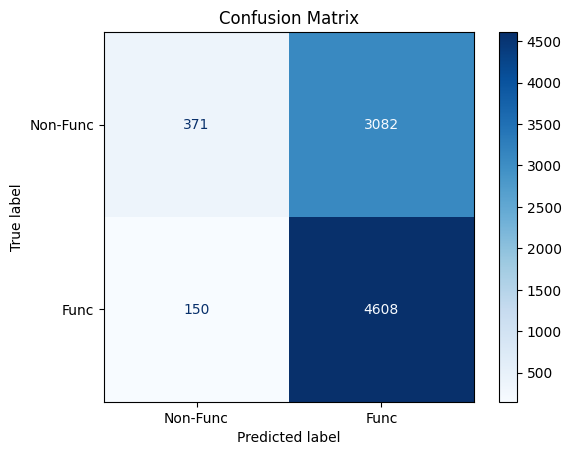

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.71      0.11      0.19      3453
        Func       0.60      0.97      0.74      4758

    accuracy                           0.61      8211
   macro avg       0.66      0.54      0.46      8211
weighted avg       0.65      0.61      0.51      8211

Confusion Matrix for Validation
37/37 [==============================] - 0s 2ms/step
256 919 1175


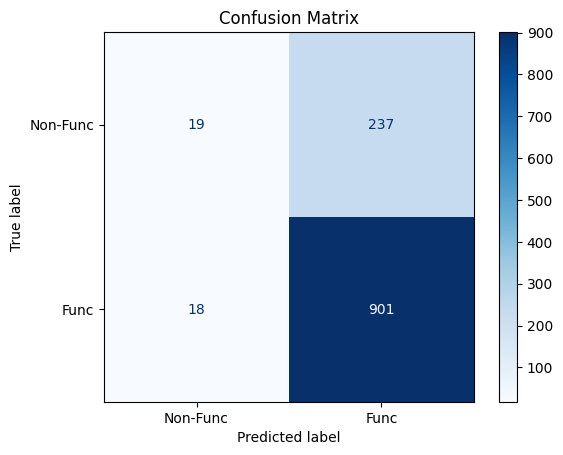

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.51      0.07      0.13       256
        Func       0.79      0.98      0.88       919

    accuracy                           0.78      1175
   macro avg       0.65      0.53      0.50      1175
weighted avg       0.73      0.78      0.71      1175



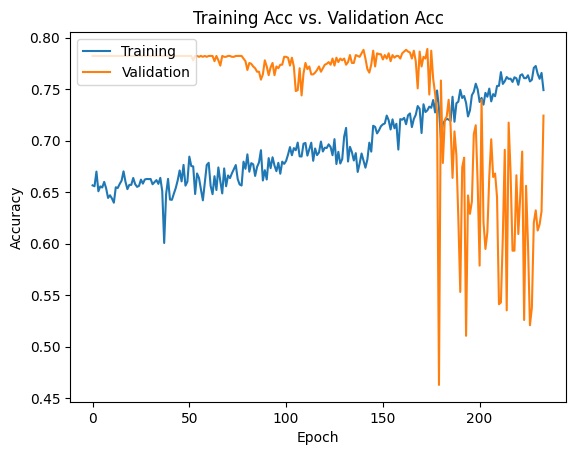

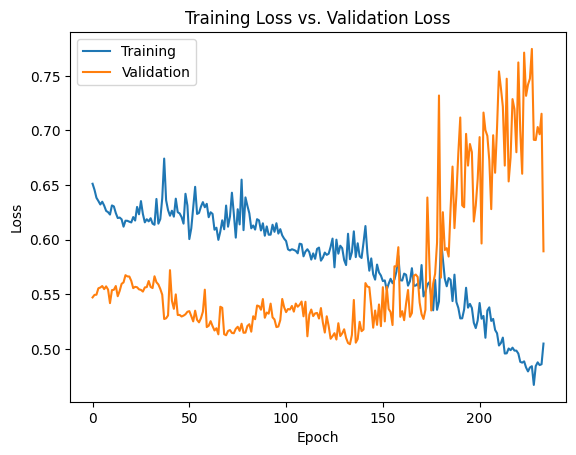

Z train:  [104 105 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [106]
Train:  3437 4952
Val:  272 725
class weights:  [1.22039569 0.8470315 ]
Epoch 1/5000
132/132 - 4s - loss: 0.6396 - binary_accuracy: 0.6587 - f1_m: 0.5385 - val_loss: 0.7778 - val_binary_accuracy: 0.7272 - val_f1_m: 0.8059 - lr: 0.0010 - 4s/epoch - 28ms/step
Epoch 2/5000
132/132 - 1s - loss: 0.6424 - binary_accuracy: 0.6727 - f1_m: 0.5631 - val_loss: 0.7720 - val_binary_accuracy: 0.7272 - val_f1_m: 0.8059 - lr: 0.0010 - 745ms/epoch - 6ms/step
Epoch 3/5000
132/132 - 1s - loss: 0.6365 - binary_accuracy: 0.6641 - f1_m: 0.5494 - val_loss: 0.7617 - val_binary_accuracy: 0.7272 - val_f1_m: 0.8059 - lr: 0.0010 - 755ms/epoch - 6ms/step
Epoch 4/5000
132/132 - 1s - loss: 0.6372 - binary_accuracy: 0.6729 - f1_m: 0.5482 - val_loss: 0.7776 - val_binary_accuracy: 0.7272 - val_f1_m: 0.8059 - lr: 0.0010 - 780ms/epoch - 6ms/step
Epoch 5/5000
132/132 - 1s - loss: 0.6353 - binary_accuracy: 0.6730 

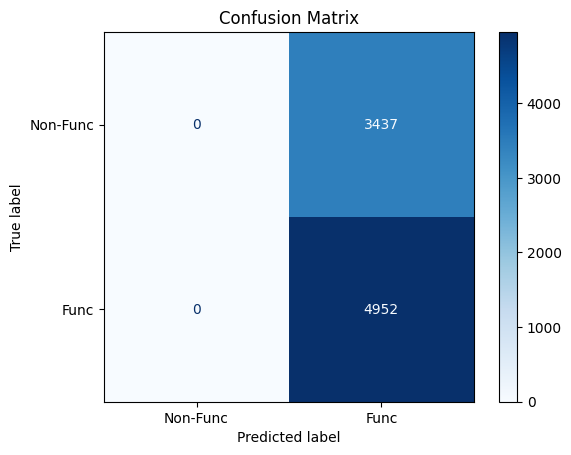

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3437
        Func       0.59      1.00      0.74      4952

    accuracy                           0.59      8389
   macro avg       0.30      0.50      0.37      8389
weighted avg       0.35      0.59      0.44      8389

Confusion Matrix for Validation
32/32 [==============================] - 0s 2ms/step
272 725 997


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


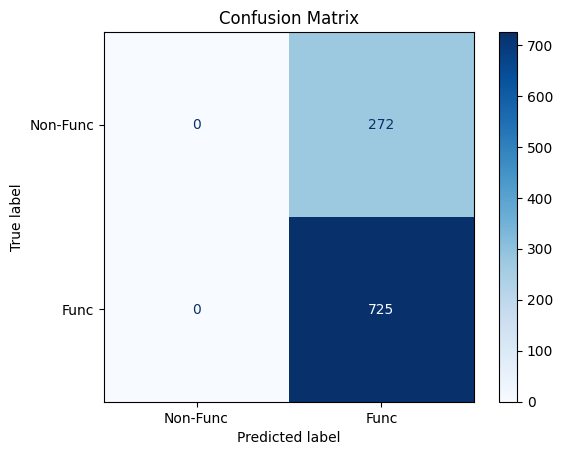

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00       272
        Func       0.73      1.00      0.84       725

    accuracy                           0.73       997
   macro avg       0.36      0.50      0.42       997
weighted avg       0.53      0.73      0.61       997



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


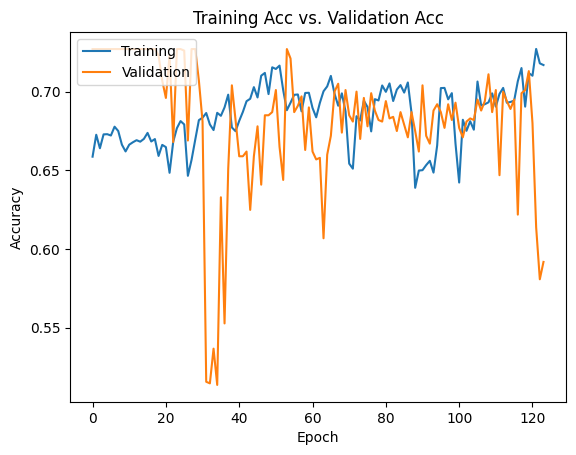

Z train:  [104 105 106 107 109 114 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [108]
Train:  3645 5035
Val:  64 642
class weights:  [1.19067215 0.86196624]
Epoch 1/5000
136/136 - 3s - loss: 0.6682 - binary_accuracy: 0.6457 - f1_m: 0.5290 - val_loss: 0.5600 - val_binary_accuracy: 0.9093 - val_f1_m: 0.9540 - lr: 0.0010 - 3s/epoch - 25ms/step
Epoch 2/5000
136/136 - 1s - loss: 0.6629 - binary_accuracy: 0.6577 - f1_m: 0.5545 - val_loss: 0.5163 - val_binary_accuracy: 0.9093 - val_f1_m: 0.9540 - lr: 0.0010 - 828ms/epoch - 6ms/step
Epoch 3/5000
136/136 - 1s - loss: 0.6667 - binary_accuracy: 0.6571 - f1_m: 0.5423 - val_loss: 0.5105 - val_binary_accuracy: 0.9093 - val_f1_m: 0.9540 - lr: 0.0010 - 798ms/epoch - 6ms/step
Epoch 4/5000
136/136 - 1s - loss: 0.6639 - binary_accuracy: 0.6442 - f1_m: 0.5310 - val_loss: 0.5145 - val_binary_accuracy: 0.9093 - val_f1_m: 0.9540 - lr: 0.0010 - 806ms/epoch - 6ms/step
Epoch 5/5000
136/136 - 1s - loss: 0.6637 - binary_accuracy: 0.6508 -

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.64      0.44      0.52      3645
        Func       0.67      0.82      0.74      5035

    accuracy                           0.66      8680
   macro avg       0.66      0.63      0.63      8680
weighted avg       0.66      0.66      0.65      8680

Confusion Matrix for Validation
23/23 [==============================] - 0s 2ms/step
64 642 706


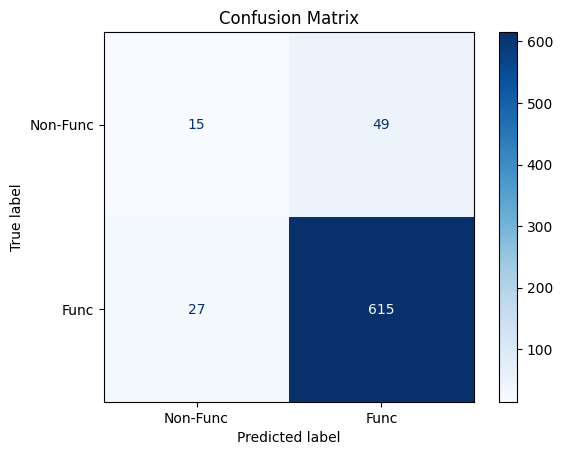

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.36      0.23      0.28        64
        Func       0.93      0.96      0.94       642

    accuracy                           0.89       706
   macro avg       0.64      0.60      0.61       706
weighted avg       0.87      0.89      0.88       706



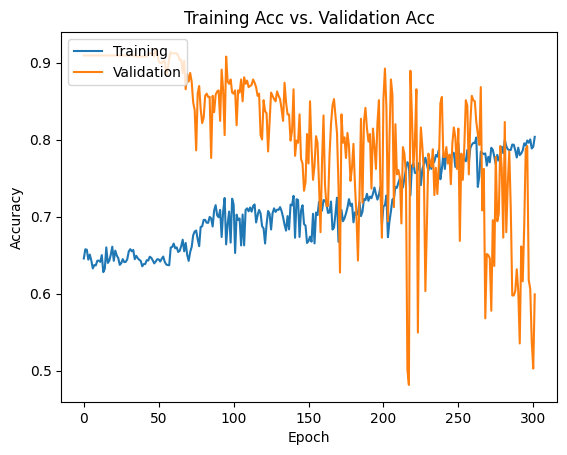

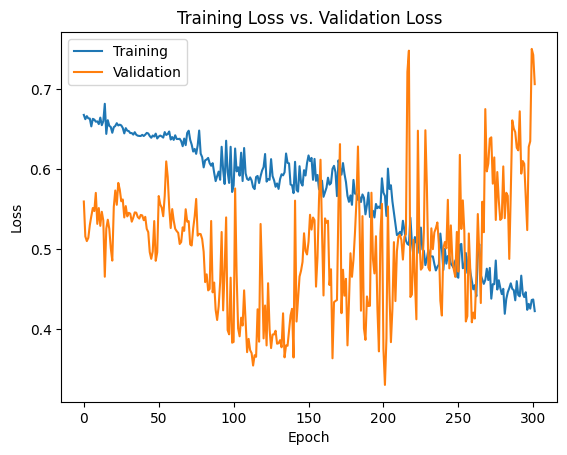

Z train:  [105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [104]
Train:  3238 5451
Val:  471 226
class weights:  [1.34172329 0.79700972]
Epoch 1/5000
136/136 - 3s - loss: 0.6364 - binary_accuracy: 0.6658 - f1_m: 0.6116 - val_loss: 1.4940 - val_binary_accuracy: 0.3242 - val_f1_m: 0.4510 - lr: 0.0010 - 3s/epoch - 25ms/step
Epoch 2/5000
136/136 - 1s - loss: 0.6373 - binary_accuracy: 0.6682 - f1_m: 0.6271 - val_loss: 1.5139 - val_binary_accuracy: 0.3242 - val_f1_m: 0.4510 - lr: 0.0010 - 791ms/epoch - 6ms/step
Epoch 3/5000
136/136 - 1s - loss: 0.6330 - binary_accuracy: 0.6758 - f1_m: 0.6248 - val_loss: 1.4497 - val_binary_accuracy: 0.3242 - val_f1_m: 0.4510 - lr: 0.0010 - 832ms/epoch - 6ms/step
Epoch 4/5000
136/136 - 1s - loss: 0.6339 - binary_accuracy: 0.6738 - f1_m: 0.6237 - val_loss: 1.5107 - val_binary_accuracy: 0.3242 - val_f1_m: 0.4510 - lr: 0.0010 - 790ms/epoch - 6ms/step
Epoch 5/5000
136/136 - 1s - loss: 0.6231 - binary_accuracy: 0.6813 

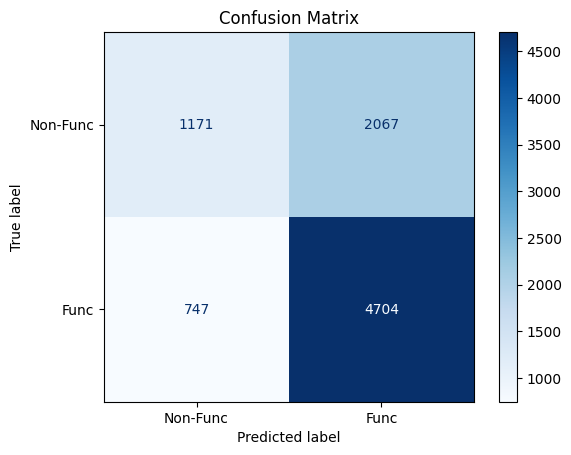

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.61      0.36      0.45      3238
        Func       0.69      0.86      0.77      5451

    accuracy                           0.68      8689
   macro avg       0.65      0.61      0.61      8689
weighted avg       0.66      0.68      0.65      8689

Confusion Matrix for Validation
22/22 [==============================] - 0s 2ms/step
471 226 697


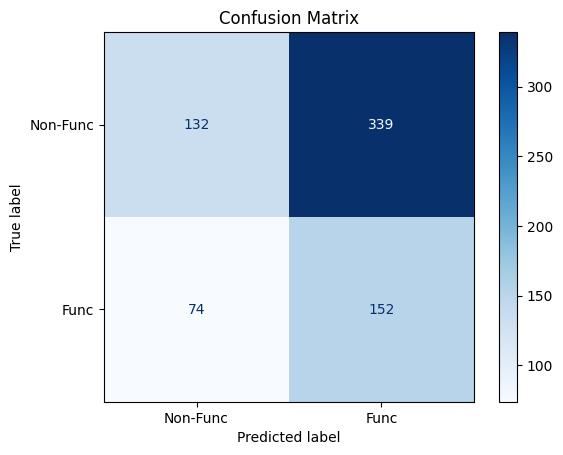

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.64      0.28      0.39       471
        Func       0.31      0.67      0.42       226

    accuracy                           0.41       697
   macro avg       0.48      0.48      0.41       697
weighted avg       0.53      0.41      0.40       697



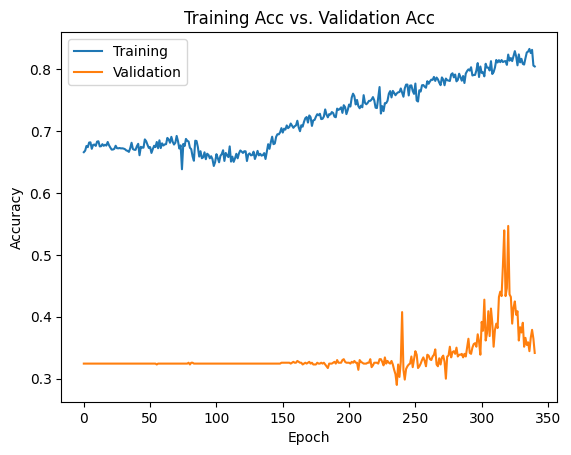

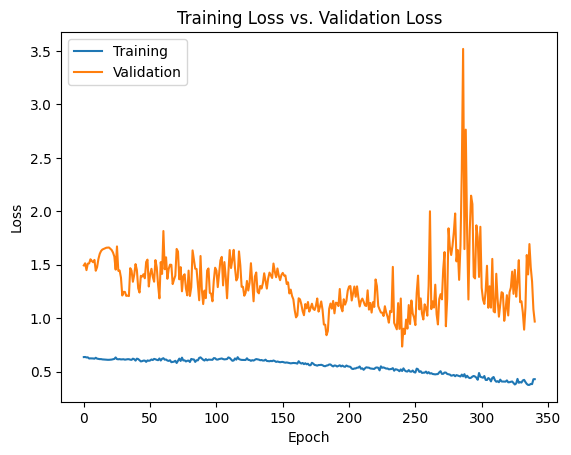

Z train:  [104 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [105]
Train:  3592 5144
Val:  117 533
class weights:  [1.21603563 0.84914463]
Epoch 1/5000
137/137 - 3s - loss: 0.6422 - binary_accuracy: 0.6683 - f1_m: 0.5411 - val_loss: 0.5114 - val_binary_accuracy: 0.8200 - val_f1_m: 0.8902 - lr: 0.0010 - 3s/epoch - 25ms/step
Epoch 2/5000
137/137 - 1s - loss: 0.6388 - binary_accuracy: 0.6641 - f1_m: 0.5535 - val_loss: 0.5103 - val_binary_accuracy: 0.8200 - val_f1_m: 0.8902 - lr: 0.0010 - 735ms/epoch - 5ms/step
Epoch 3/5000
137/137 - 1s - loss: 0.6438 - binary_accuracy: 0.6659 - f1_m: 0.5515 - val_loss: 0.5097 - val_binary_accuracy: 0.8200 - val_f1_m: 0.8902 - lr: 0.0010 - 794ms/epoch - 6ms/step
Epoch 4/5000
137/137 - 1s - loss: 0.6439 - binary_accuracy: 0.6596 - f1_m: 0.5415 - val_loss: 0.5087 - val_binary_accuracy: 0.8200 - val_f1_m: 0.8902 - lr: 0.0010 - 851ms/epoch - 6ms/step
Epoch 5/5000
137/137 - 1s - loss: 0.6356 - binary_accuracy: 0.6687 

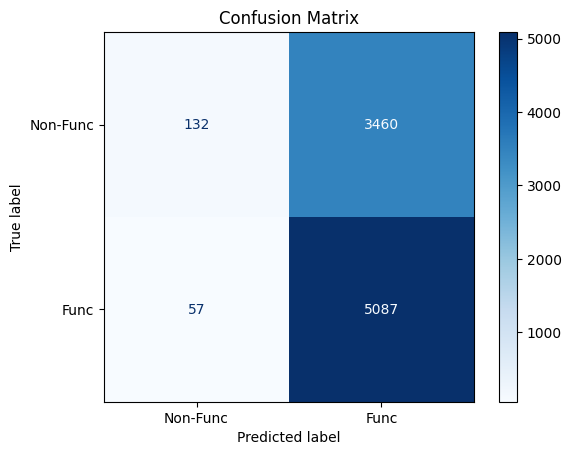

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.70      0.04      0.07      3592
        Func       0.60      0.99      0.74      5144

    accuracy                           0.60      8736
   macro avg       0.65      0.51      0.41      8736
weighted avg       0.64      0.60      0.47      8736

Confusion Matrix for Validation
21/21 [==============================] - 0s 2ms/step
117 533 650


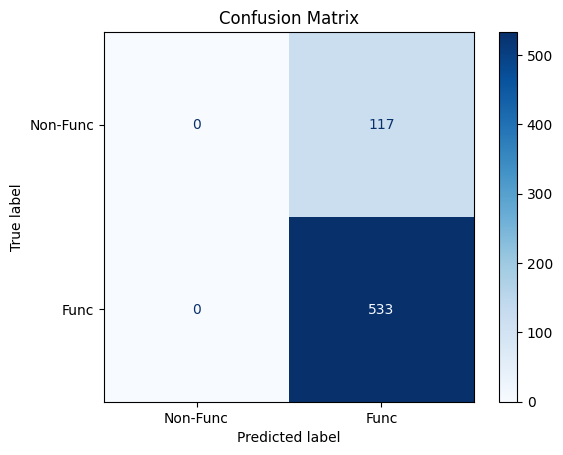

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00       117
        Func       0.82      1.00      0.90       533

    accuracy                           0.82       650
   macro avg       0.41      0.50      0.45       650
weighted avg       0.67      0.82      0.74       650



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


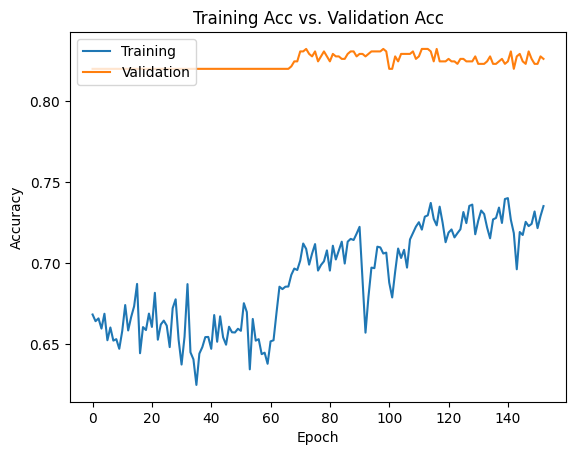

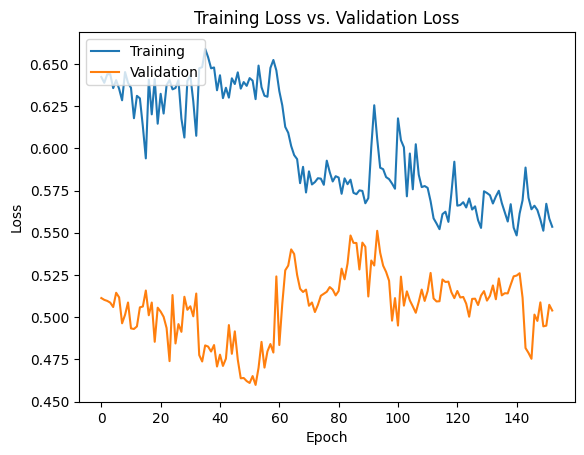

Z train:  [104 105 106 108 109 114 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [107]
Train:  3623 5223
Val:  86 454
class weights:  [1.22081148 0.84683132]
Epoch 1/5000
139/139 - 4s - loss: 0.6400 - binary_accuracy: 0.6699 - f1_m: 0.5407 - val_loss: 0.4740 - val_binary_accuracy: 0.8407 - val_f1_m: 0.9091 - lr: 0.0010 - 4s/epoch - 30ms/step
Epoch 2/5000
139/139 - 1s - loss: 0.6376 - binary_accuracy: 0.6667 - f1_m: 0.5466 - val_loss: 0.4705 - val_binary_accuracy: 0.8407 - val_f1_m: 0.9091 - lr: 0.0010 - 842ms/epoch - 6ms/step
Epoch 3/5000
139/139 - 1s - loss: 0.6381 - binary_accuracy: 0.6680 - f1_m: 0.5436 - val_loss: 0.4711 - val_binary_accuracy: 0.8407 - val_f1_m: 0.9091 - lr: 0.0010 - 794ms/epoch - 6ms/step
Epoch 4/5000
139/139 - 1s - loss: 0.6353 - binary_accuracy: 0.6725 - f1_m: 0.5670 - val_loss: 0.4744 - val_binary_accuracy: 0.8407 - val_f1_m: 0.9091 - lr: 0.0010 - 787ms/epoch - 6ms/step
Epoch 5/5000
139/139 - 1s - loss: 0.6340 - binary_accuracy: 0.6727 -

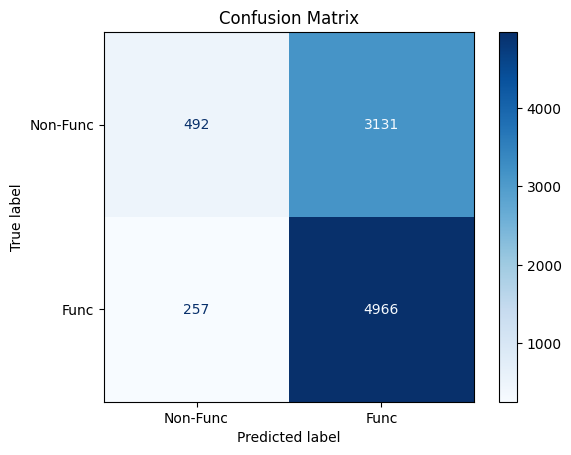

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.66      0.14      0.23      3623
        Func       0.61      0.95      0.75      5223

    accuracy                           0.62      8846
   macro avg       0.64      0.54      0.49      8846
weighted avg       0.63      0.62      0.53      8846

Confusion Matrix for Validation
17/17 [==============================] - 0s 2ms/step
86 454 540


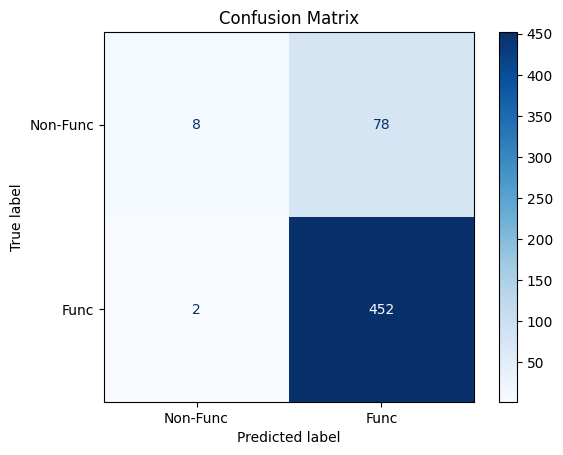

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.80      0.09      0.17        86
        Func       0.85      1.00      0.92       454

    accuracy                           0.85       540
   macro avg       0.83      0.54      0.54       540
weighted avg       0.84      0.85      0.80       540



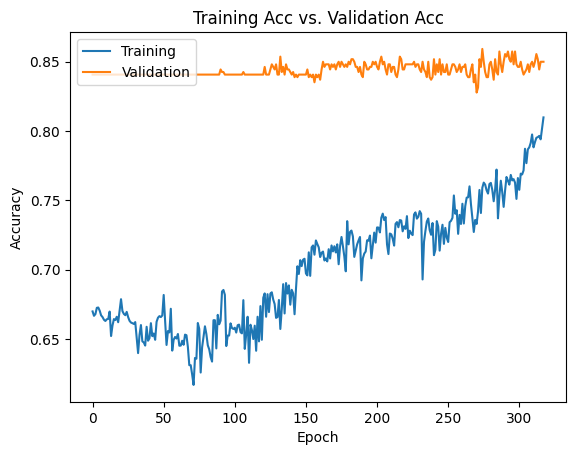

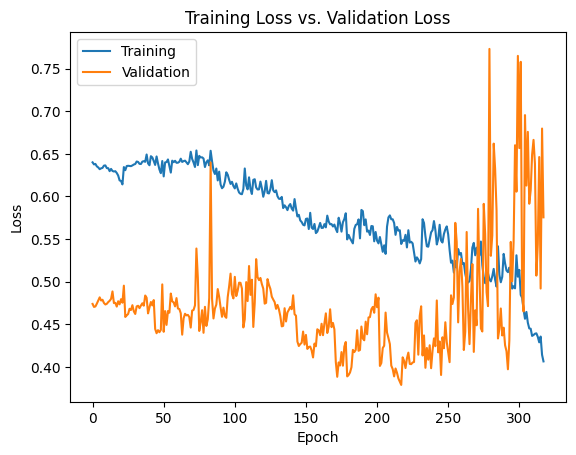

Z train:  [104 105 106 107 108 109 114 116 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [118]
Train:  3636 5219
Val:  73 458
class weights:  [1.21768427 0.84834259]
Epoch 1/5000
139/139 - 3s - loss: 0.6355 - binary_accuracy: 0.6780 - f1_m: 0.5271 - val_loss: 0.4037 - val_binary_accuracy: 0.8625 - val_f1_m: 0.9064 - lr: 0.0010 - 3s/epoch - 24ms/step
Epoch 2/5000
139/139 - 1s - loss: 0.6273 - binary_accuracy: 0.6967 - f1_m: 0.5546 - val_loss: 0.4030 - val_binary_accuracy: 0.8625 - val_f1_m: 0.9064 - lr: 0.0010 - 891ms/epoch - 6ms/step
Epoch 3/5000
139/139 - 1s - loss: 0.6324 - binary_accuracy: 0.6766 - f1_m: 0.5346 - val_loss: 0.4011 - val_binary_accuracy: 0.8625 - val_f1_m: 0.9064 - lr: 0.0010 - 857ms/epoch - 6ms/step
Epoch 4/5000
139/139 - 1s - loss: 0.6258 - binary_accuracy: 0.6927 - f1_m: 0.5517 - val_loss: 0.4001 - val_binary_accuracy: 0.8625 - val_f1_m: 0.9064 - lr: 0.0010 - 763ms/epoch - 5ms/step
Epoch 5/5000
139/139 - 1s - loss: 0.6317 - binary_accuracy: 0.6828 -

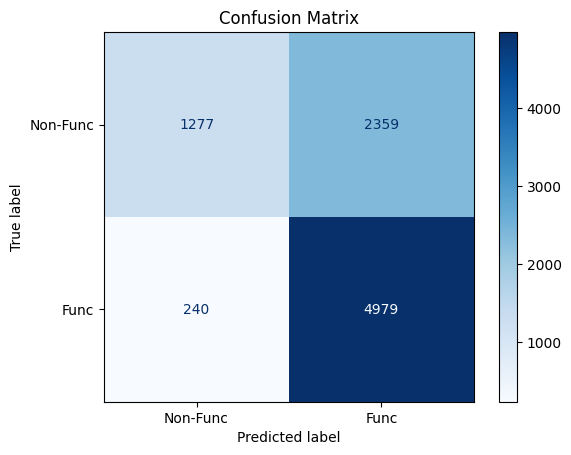

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.84      0.35      0.50      3636
        Func       0.68      0.95      0.79      5219

    accuracy                           0.71      8855
   macro avg       0.76      0.65      0.64      8855
weighted avg       0.75      0.71      0.67      8855

Confusion Matrix for Validation
17/17 [==============================] - 0s 2ms/step
73 458 531


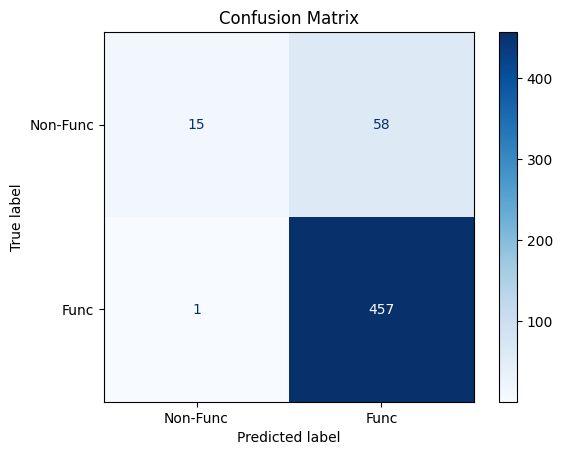

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.94      0.21      0.34        73
        Func       0.89      1.00      0.94       458

    accuracy                           0.89       531
   macro avg       0.91      0.60      0.64       531
weighted avg       0.89      0.89      0.86       531



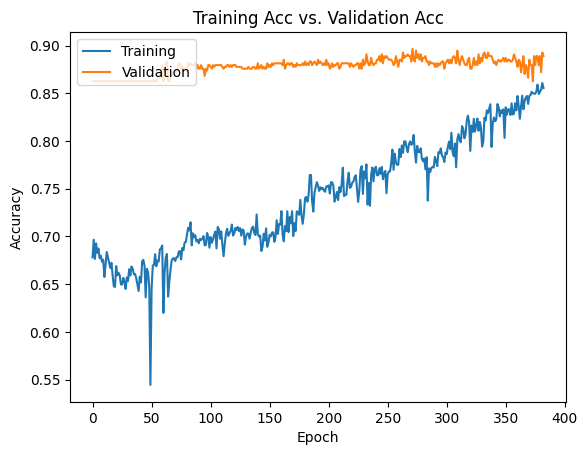

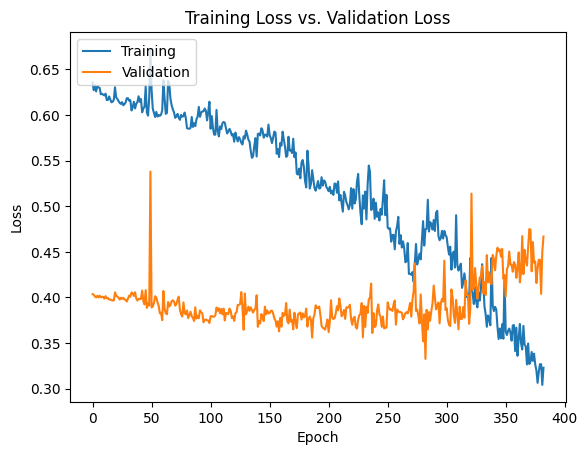

Z train:  [104 105 106 107 108 109 114 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [116]
Train:  3483 5456
Val:  226 221
class weights:  [1.28323285 0.81918988]
Epoch 1/5000
140/140 - 5s - loss: 0.6293 - binary_accuracy: 0.6852 - f1_m: 0.5700 - val_loss: 1.2694 - val_binary_accuracy: 0.4944 - val_f1_m: 0.6004 - lr: 0.0010 - 5s/epoch - 37ms/step
Epoch 2/5000
140/140 - 1s - loss: 0.6307 - binary_accuracy: 0.6787 - f1_m: 0.5688 - val_loss: 1.2668 - val_binary_accuracy: 0.4944 - val_f1_m: 0.6004 - lr: 0.0010 - 901ms/epoch - 6ms/step
Epoch 3/5000
140/140 - 1s - loss: 0.6255 - binary_accuracy: 0.6891 - f1_m: 0.5731 - val_loss: 1.2643 - val_binary_accuracy: 0.4944 - val_f1_m: 0.6004 - lr: 0.0010 - 976ms/epoch - 7ms/step
Epoch 4/5000
140/140 - 1s - loss: 0.6262 - binary_accuracy: 0.6897 - f1_m: 0.5671 - val_loss: 1.2739 - val_binary_accuracy: 0.4944 - val_f1_m: 0.6004 - lr: 0.0010 - 876ms/epoch - 6ms/step
Epoch 5/5000
140/140 - 1s - loss: 0.6274 - binary_accuracy: 0.6853 

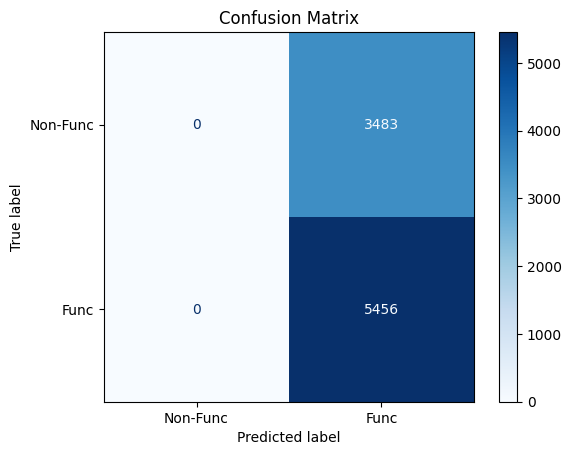

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3483
        Func       0.61      1.00      0.76      5456

    accuracy                           0.61      8939
   macro avg       0.31      0.50      0.38      8939
weighted avg       0.37      0.61      0.46      8939

Confusion Matrix for Validation
14/14 [==============================] - 0s 2ms/step
226 221 447


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


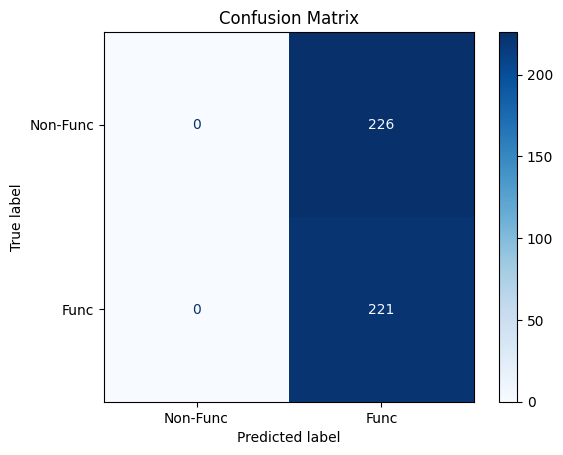

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00       226
        Func       0.49      1.00      0.66       221

    accuracy                           0.49       447
   macro avg       0.25      0.50      0.33       447
weighted avg       0.24      0.49      0.33       447



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


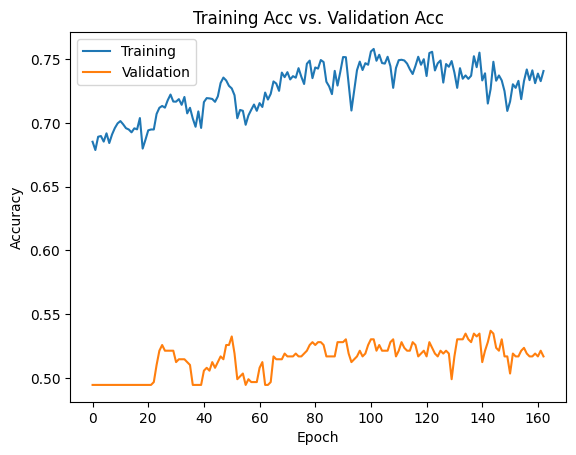

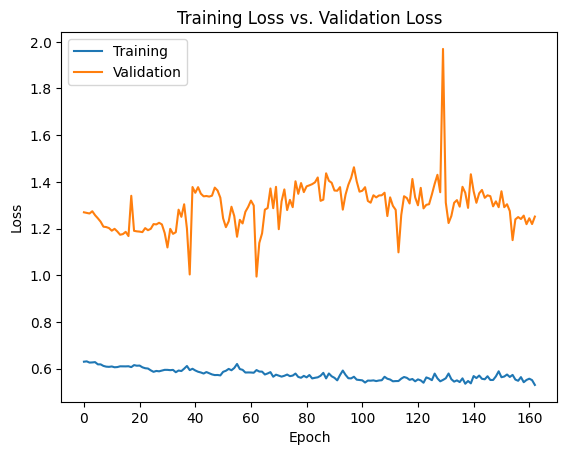

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 126 129 132 133 136 138
 139 140 141]
Z val:  [125]
Train:  3521 5431
Val:  188 246
class weights:  [1.27122976 0.82415761]
Epoch 1/5000
140/140 - 3s - loss: 0.6376 - binary_accuracy: 0.6912 - f1_m: 0.5735 - val_loss: 0.8952 - val_binary_accuracy: 0.5668 - val_f1_m: 0.6931 - lr: 0.0010 - 3s/epoch - 25ms/step
Epoch 2/5000
140/140 - 1s - loss: 0.6359 - binary_accuracy: 0.6895 - f1_m: 0.5694 - val_loss: 0.8963 - val_binary_accuracy: 0.5668 - val_f1_m: 0.6931 - lr: 0.0010 - 861ms/epoch - 6ms/step
Epoch 3/5000
140/140 - 1s - loss: 0.6346 - binary_accuracy: 0.6873 - f1_m: 0.5738 - val_loss: 0.9396 - val_binary_accuracy: 0.5668 - val_f1_m: 0.6931 - lr: 0.0010 - 919ms/epoch - 7ms/step
Epoch 4/5000
140/140 - 1s - loss: 0.6334 - binary_accuracy: 0.6825 - f1_m: 0.5721 - val_loss: 0.9641 - val_binary_accuracy: 0.5668 - val_f1_m: 0.6931 - lr: 0.0010 - 865ms/epoch - 6ms/step
Epoch 5/5000
140/140 - 1s - loss: 0.6285 - binary_accuracy: 0.6905 

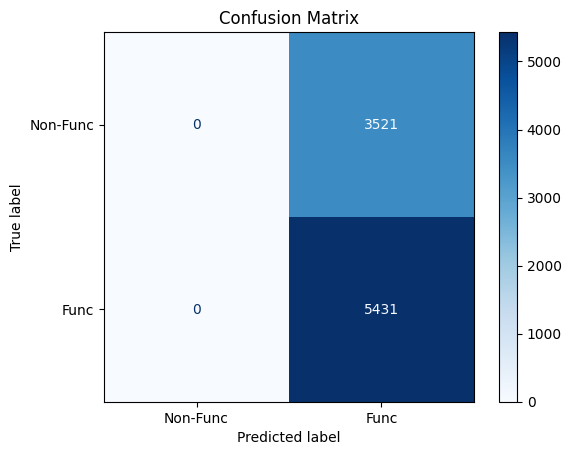

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3521
        Func       0.61      1.00      0.76      5431

    accuracy                           0.61      8952
   macro avg       0.30      0.50      0.38      8952
weighted avg       0.37      0.61      0.46      8952

Confusion Matrix for Validation
14/14 [==============================] - 0s 2ms/step
188 246 434


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


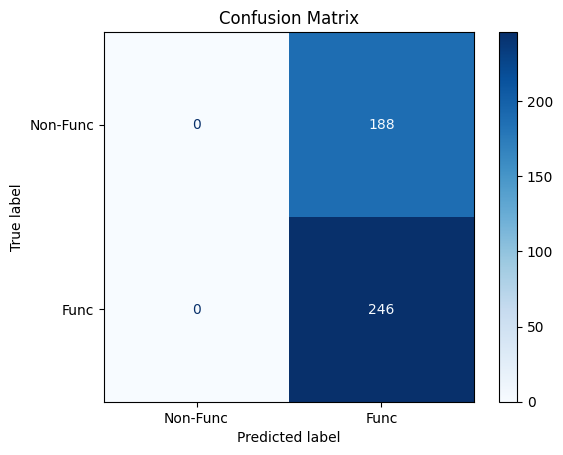

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00       188
        Func       0.57      1.00      0.72       246

    accuracy                           0.57       434
   macro avg       0.28      0.50      0.36       434
weighted avg       0.32      0.57      0.41       434



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


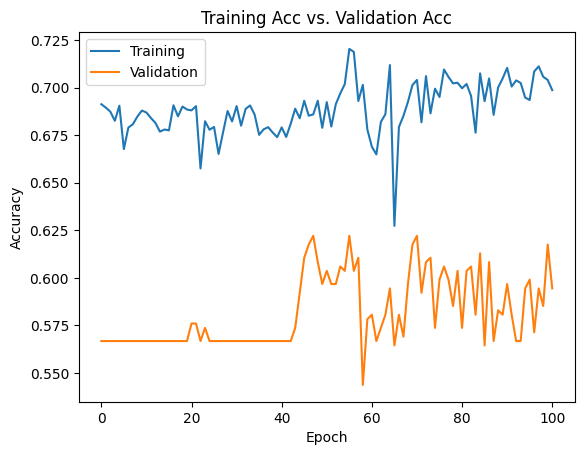

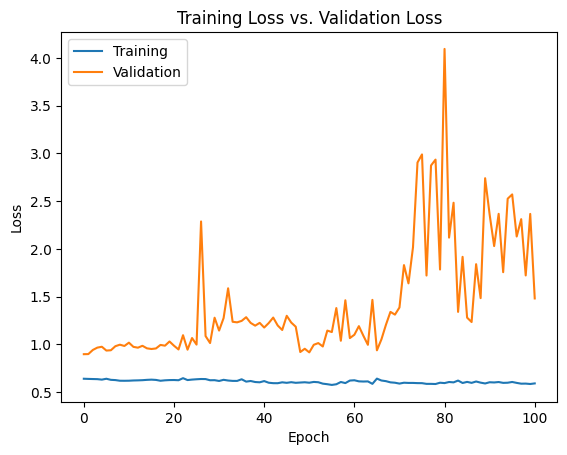

Z train:  [104 105 106 107 108 109 114 116 118 119 121 125 126 129 132 133 136 138
 139 140 141]
Z val:  [122]
Train:  3288 5667
Val:  421 10
class weights:  [1.36177007 0.79010058]
Epoch 1/5000
140/140 - 4s - loss: 0.6360 - binary_accuracy: 0.6842 - f1_m: 0.6354 - val_loss: 2.1219 - val_binary_accuracy: 0.0232 - val_f1_m: 0.0396 - lr: 0.0010 - 4s/epoch - 28ms/step
Epoch 2/5000
140/140 - 1s - loss: 0.6371 - binary_accuracy: 0.6719 - f1_m: 0.6379 - val_loss: 2.1541 - val_binary_accuracy: 0.0232 - val_f1_m: 0.0396 - lr: 0.0010 - 826ms/epoch - 6ms/step
Epoch 3/5000
140/140 - 1s - loss: 0.6339 - binary_accuracy: 0.6854 - f1_m: 0.6397 - val_loss: 2.1122 - val_binary_accuracy: 0.0232 - val_f1_m: 0.0396 - lr: 0.0010 - 827ms/epoch - 6ms/step
Epoch 4/5000
140/140 - 1s - loss: 0.6286 - binary_accuracy: 0.6840 - f1_m: 0.6418 - val_loss: 2.1580 - val_binary_accuracy: 0.0232 - val_f1_m: 0.0396 - lr: 0.0010 - 846ms/epoch - 6ms/step
Epoch 5/5000
140/140 - 1s - loss: 0.6268 - binary_accuracy: 0.6836 -

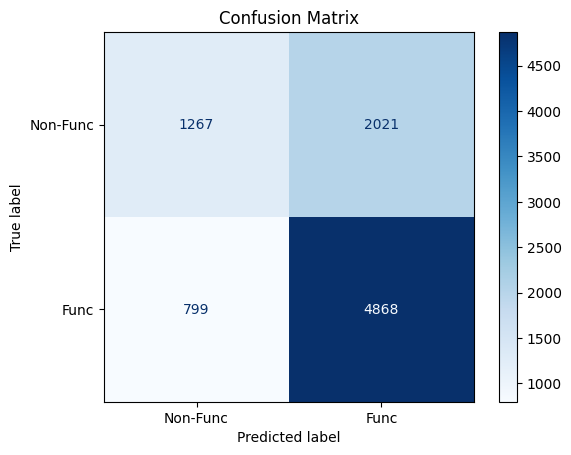

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.61      0.39      0.47      3288
        Func       0.71      0.86      0.78      5667

    accuracy                           0.69      8955
   macro avg       0.66      0.62      0.62      8955
weighted avg       0.67      0.69      0.66      8955

Confusion Matrix for Validation
14/14 [==============================] - 0s 2ms/step
421 10 431


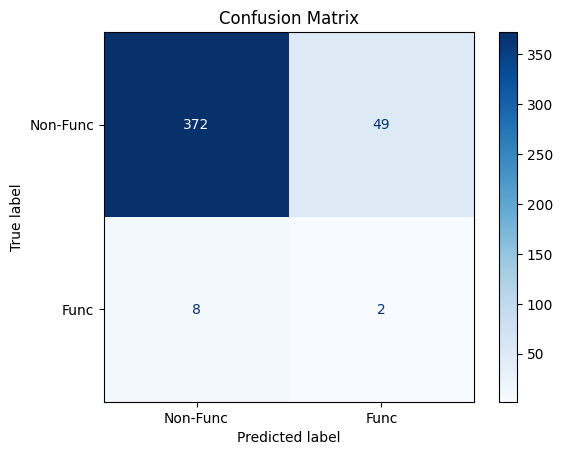

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.98      0.88      0.93       421
        Func       0.04      0.20      0.07        10

    accuracy                           0.87       431
   macro avg       0.51      0.54      0.50       431
weighted avg       0.96      0.87      0.91       431



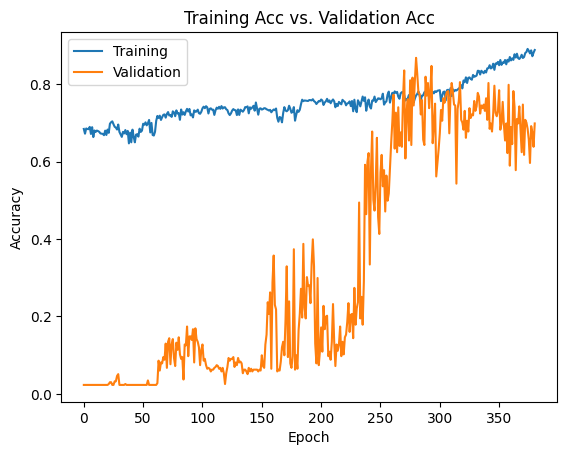

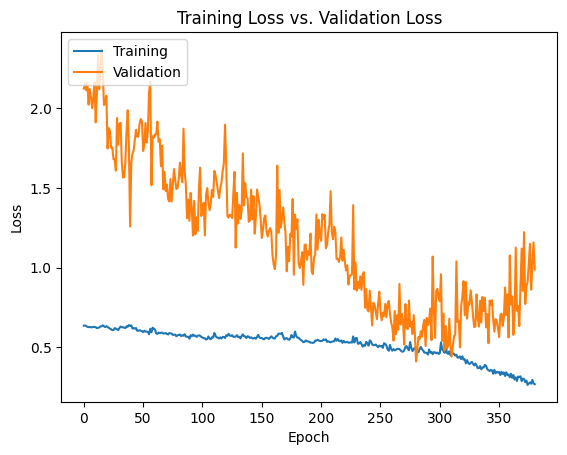

Z train:  [104 105 106 107 108 109 114 116 118 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [119]
Train:  3518 5438
Val:  191 239
class weights:  [1.27288232 0.82346451]
Epoch 1/5000
140/140 - 3s - loss: 0.6369 - binary_accuracy: 0.6783 - f1_m: 0.6063 - val_loss: 1.0665 - val_binary_accuracy: 0.5558 - val_f1_m: 0.6414 - lr: 0.0010 - 3s/epoch - 25ms/step
Epoch 2/5000
140/140 - 1s - loss: 0.6276 - binary_accuracy: 0.6864 - f1_m: 0.6057 - val_loss: 1.0789 - val_binary_accuracy: 0.5558 - val_f1_m: 0.6414 - lr: 0.0010 - 892ms/epoch - 6ms/step
Epoch 3/5000
140/140 - 1s - loss: 0.6241 - binary_accuracy: 0.6851 - f1_m: 0.6047 - val_loss: 1.0626 - val_binary_accuracy: 0.5558 - val_f1_m: 0.6414 - lr: 0.0010 - 786ms/epoch - 6ms/step
Epoch 4/5000
140/140 - 1s - loss: 0.6207 - binary_accuracy: 0.6925 - f1_m: 0.5975 - val_loss: 1.0657 - val_binary_accuracy: 0.5558 - val_f1_m: 0.6414 - lr: 0.0010 - 794ms/epoch - 6ms/step
Epoch 5/5000
140/140 - 1s - loss: 0.6173 - binary_accuracy: 0.6909 

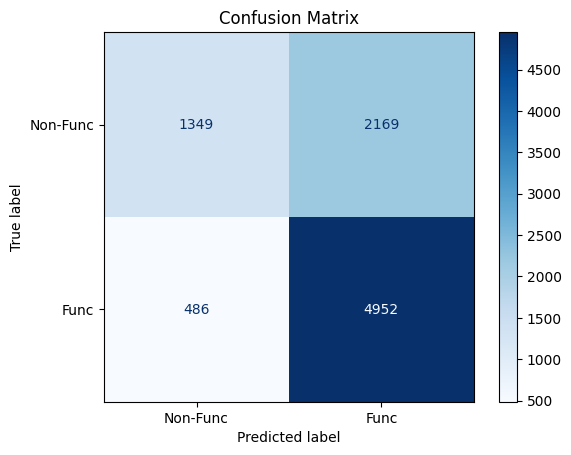

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.74      0.38      0.50      3518
        Func       0.70      0.91      0.79      5438

    accuracy                           0.70      8956
   macro avg       0.72      0.65      0.65      8956
weighted avg       0.71      0.70      0.68      8956

Confusion Matrix for Validation
14/14 [==============================] - 0s 2ms/step
191 239 430


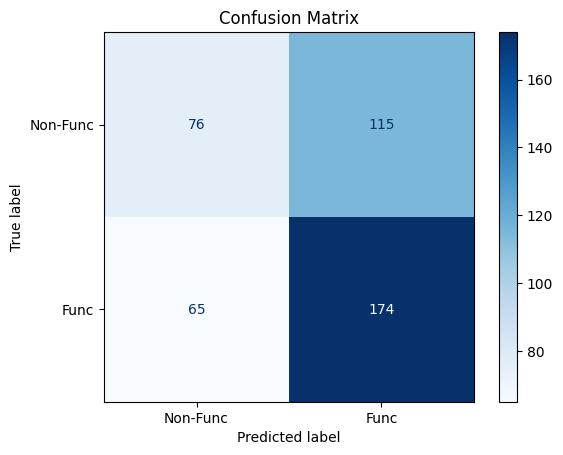

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.54      0.40      0.46       191
        Func       0.60      0.73      0.66       239

    accuracy                           0.58       430
   macro avg       0.57      0.56      0.56       430
weighted avg       0.57      0.58      0.57       430



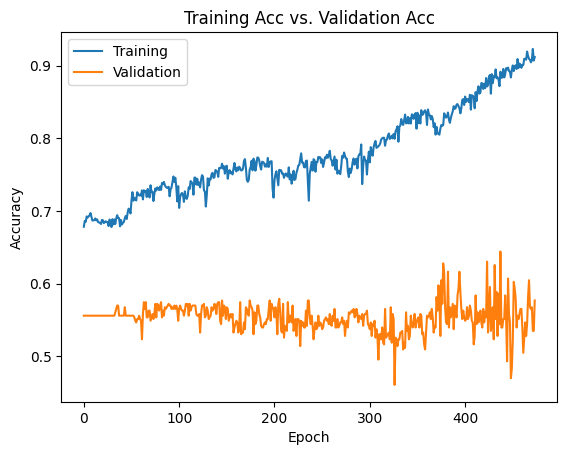

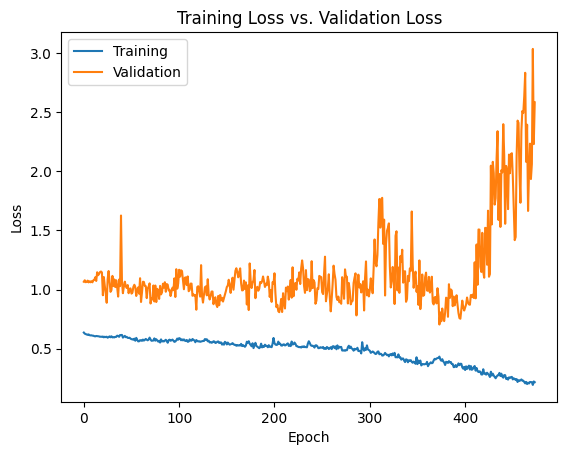

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 129 132 133 136 138
 139 140 141]
Z val:  [126]
Train:  3646 5351
Val:  63 326
class weights:  [1.23381788 0.84068398]
Epoch 1/5000
141/141 - 4s - loss: 0.6368 - binary_accuracy: 0.6769 - f1_m: 0.5253 - val_loss: 0.4511 - val_binary_accuracy: 0.8380 - val_f1_m: 0.8994 - lr: 0.0010 - 4s/epoch - 29ms/step
Epoch 2/5000
141/141 - 1s - loss: 0.6350 - binary_accuracy: 0.6747 - f1_m: 0.5163 - val_loss: 0.4597 - val_binary_accuracy: 0.8380 - val_f1_m: 0.8994 - lr: 0.0010 - 738ms/epoch - 5ms/step
Epoch 3/5000
141/141 - 1s - loss: 0.6457 - binary_accuracy: 0.6644 - f1_m: 0.5333 - val_loss: 0.4588 - val_binary_accuracy: 0.8380 - val_f1_m: 0.8994 - lr: 0.0010 - 775ms/epoch - 5ms/step
Epoch 4/5000
141/141 - 1s - loss: 0.6366 - binary_accuracy: 0.6734 - f1_m: 0.5173 - val_loss: 0.4588 - val_binary_accuracy: 0.8380 - val_f1_m: 0.8994 - lr: 0.0010 - 777ms/epoch - 6ms/step
Epoch 5/5000
141/141 - 1s - loss: 0.6355 - binary_accuracy: 0.6798 -

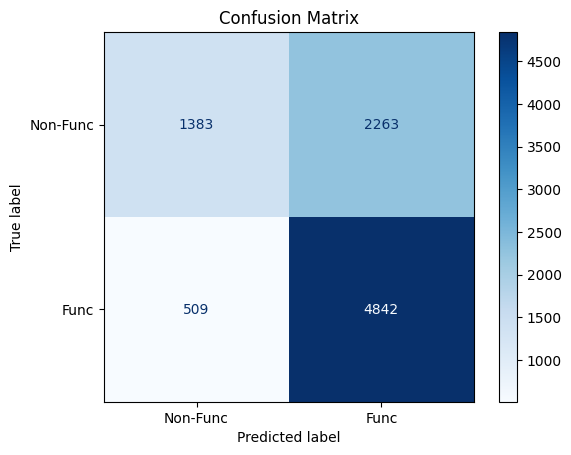

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.73      0.38      0.50      3646
        Func       0.68      0.90      0.78      5351

    accuracy                           0.69      8997
   macro avg       0.71      0.64      0.64      8997
weighted avg       0.70      0.69      0.66      8997

Confusion Matrix for Validation
13/13 [==============================] - 0s 2ms/step
63 326 389


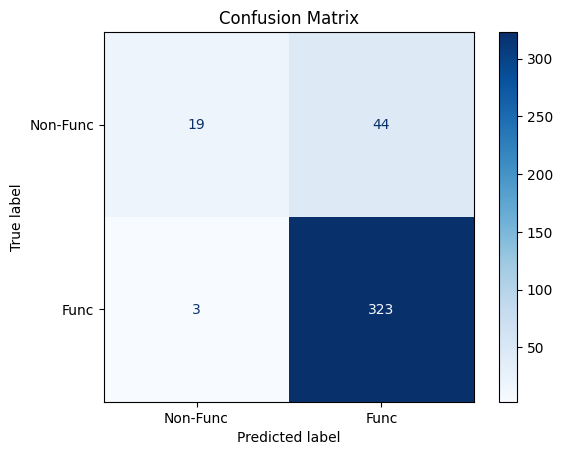

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.86      0.30      0.45        63
        Func       0.88      0.99      0.93       326

    accuracy                           0.88       389
   macro avg       0.87      0.65      0.69       389
weighted avg       0.88      0.88      0.85       389



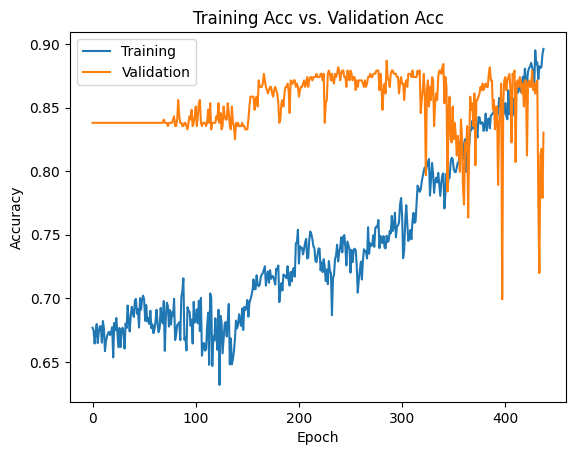

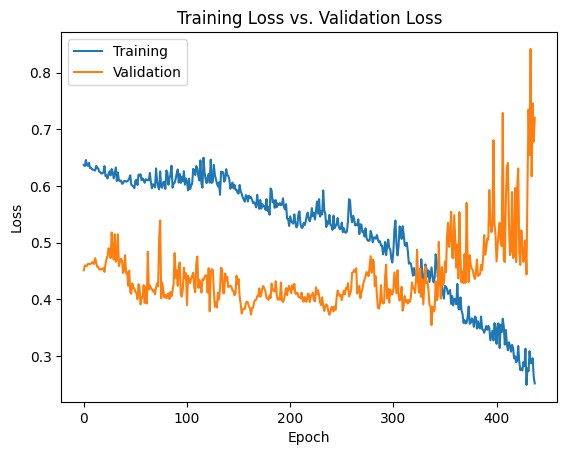

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 133 136 138
 139 140 141]
Z val:  [132]
Train:  3398 5662
Val:  311 15
class weights:  [1.33313714 0.80007065]
Epoch 1/5000
142/142 - 5s - loss: 0.6424 - binary_accuracy: 0.6485 - f1_m: 0.6158 - val_loss: 2.1166 - val_binary_accuracy: 0.0460 - val_f1_m: 0.0650 - lr: 0.0010 - 5s/epoch - 34ms/step
Epoch 2/5000
142/142 - 1s - loss: 0.6429 - binary_accuracy: 0.6614 - f1_m: 0.6118 - val_loss: 2.1694 - val_binary_accuracy: 0.0460 - val_f1_m: 0.0650 - lr: 0.0010 - 860ms/epoch - 6ms/step
Epoch 3/5000
142/142 - 1s - loss: 0.6410 - binary_accuracy: 0.6637 - f1_m: 0.6148 - val_loss: 2.1641 - val_binary_accuracy: 0.0460 - val_f1_m: 0.0650 - lr: 0.0010 - 853ms/epoch - 6ms/step
Epoch 4/5000
142/142 - 1s - loss: 0.6373 - binary_accuracy: 0.6812 - f1_m: 0.6151 - val_loss: 2.1605 - val_binary_accuracy: 0.0460 - val_f1_m: 0.0650 - lr: 0.0010 - 855ms/epoch - 6ms/step
Epoch 5/5000
142/142 - 1s - loss: 0.6333 - binary_accuracy: 0.6668 -

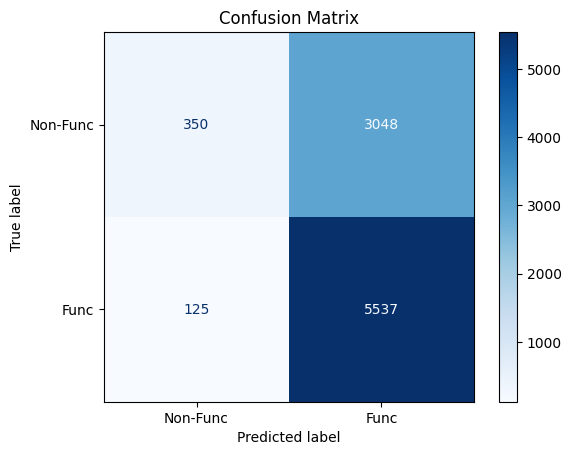

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.74      0.10      0.18      3398
        Func       0.64      0.98      0.78      5662

    accuracy                           0.65      9060
   macro avg       0.69      0.54      0.48      9060
weighted avg       0.68      0.65      0.55      9060

Confusion Matrix for Validation
11/11 [==============================] - 0s 2ms/step
311 15 326


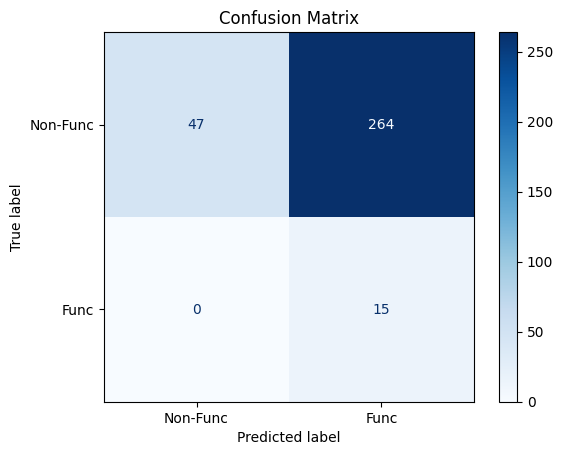

Classification Report
              precision    recall  f1-score   support

    Non-Func       1.00      0.15      0.26       311
        Func       0.05      1.00      0.10        15

    accuracy                           0.19       326
   macro avg       0.53      0.58      0.18       326
weighted avg       0.96      0.19      0.26       326



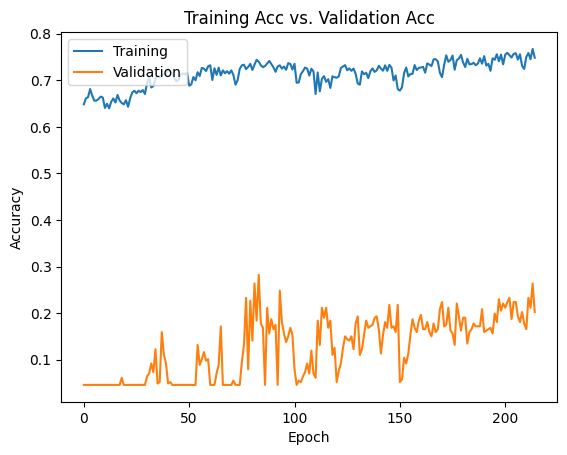

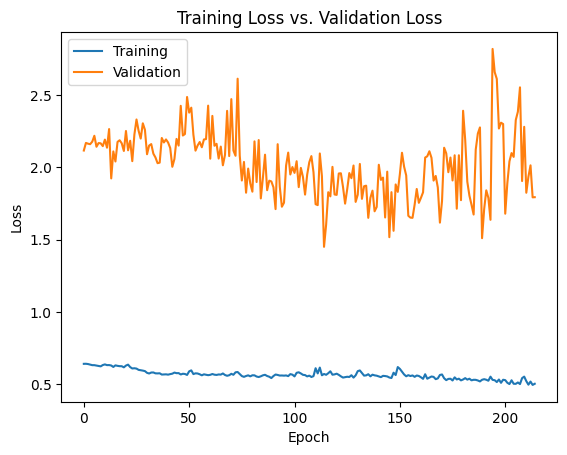

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136
 138 140 141]
Z val:  [139]
Train:  3420 5645
Val:  289 32
class weights:  [1.3252924  0.80292294]
Epoch 1/5000
142/142 - 4s - loss: 0.6294 - binary_accuracy: 0.6983 - f1_m: 0.6033 - val_loss: 2.1503 - val_binary_accuracy: 0.0997 - val_f1_m: 0.1413 - lr: 0.0010 - 4s/epoch - 25ms/step
Epoch 2/5000
142/142 - 1s - loss: 0.6213 - binary_accuracy: 0.7029 - f1_m: 0.6059 - val_loss: 2.1659 - val_binary_accuracy: 0.0997 - val_f1_m: 0.1413 - lr: 0.0010 - 880ms/epoch - 6ms/step
Epoch 3/5000
142/142 - 1s - loss: 0.6155 - binary_accuracy: 0.7097 - f1_m: 0.6135 - val_loss: 2.1412 - val_binary_accuracy: 0.0997 - val_f1_m: 0.1413 - lr: 0.0010 - 908ms/epoch - 6ms/step
Epoch 4/5000
142/142 - 1s - loss: 0.6146 - binary_accuracy: 0.7020 - f1_m: 0.6150 - val_loss: 2.2049 - val_binary_accuracy: 0.0997 - val_f1_m: 0.1413 - lr: 0.0010 - 894ms/epoch - 6ms/step
Epoch 5/5000
142/142 - 1s - loss: 0.6107 - binary_accuracy: 0.7041 -

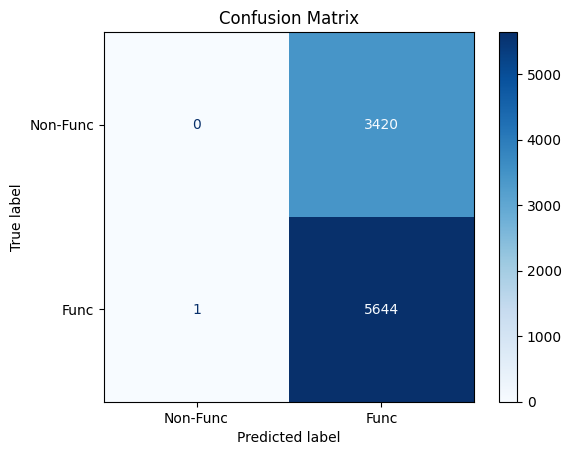

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3420
        Func       0.62      1.00      0.77      5645

    accuracy                           0.62      9065
   macro avg       0.31      0.50      0.38      9065
weighted avg       0.39      0.62      0.48      9065

Confusion Matrix for Validation
11/11 [==============================] - 0s 2ms/step
289 32 321


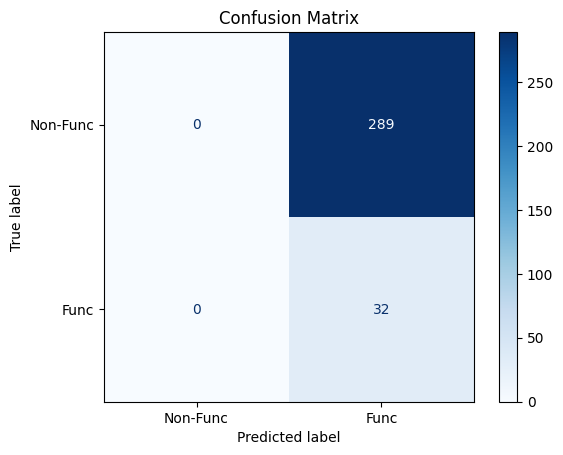

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00       289
        Func       0.10      1.00      0.18        32

    accuracy                           0.10       321
   macro avg       0.05      0.50      0.09       321
weighted avg       0.01      0.10      0.02       321



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


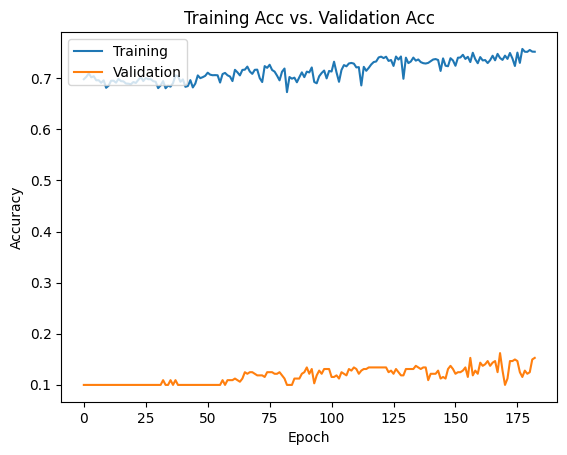

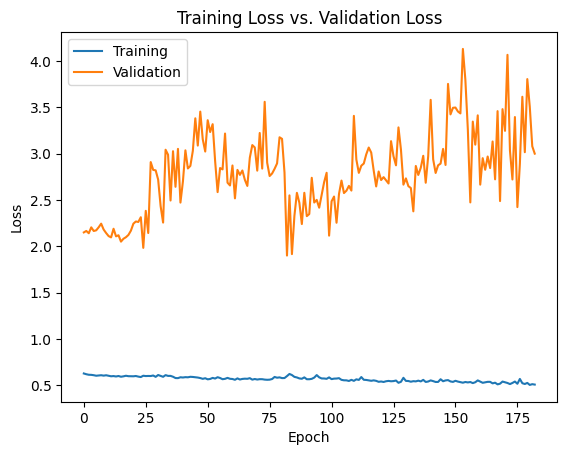

Z train:  [104 105 106 107 108 109 114 116 118 119 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [121]
Train:  3617 5536
Val:  92 141
class weights:  [1.26527509 0.82667991]
Epoch 1/5000
144/144 - 5s - loss: 0.6458 - binary_accuracy: 0.6623 - f1_m: 0.5547 - val_loss: 1.1064 - val_binary_accuracy: 0.6052 - val_f1_m: 0.7062 - lr: 0.0010 - 5s/epoch - 34ms/step
Epoch 2/5000
144/144 - 1s - loss: 0.6433 - binary_accuracy: 0.6728 - f1_m: 0.5686 - val_loss: 1.0903 - val_binary_accuracy: 0.6052 - val_f1_m: 0.7062 - lr: 0.0010 - 872ms/epoch - 6ms/step
Epoch 3/5000
144/144 - 1s - loss: 0.6447 - binary_accuracy: 0.6766 - f1_m: 0.5624 - val_loss: 1.0892 - val_binary_accuracy: 0.6052 - val_f1_m: 0.7062 - lr: 0.0010 - 848ms/epoch - 6ms/step
Epoch 4/5000
144/144 - 1s - loss: 0.6407 - binary_accuracy: 0.6740 - f1_m: 0.5676 - val_loss: 1.0615 - val_binary_accuracy: 0.6052 - val_f1_m: 0.7062 - lr: 0.0010 - 923ms/epoch - 6ms/step
Epoch 5/5000
144/144 - 1s - loss: 0.6374 - binary_accuracy: 0.6778 -

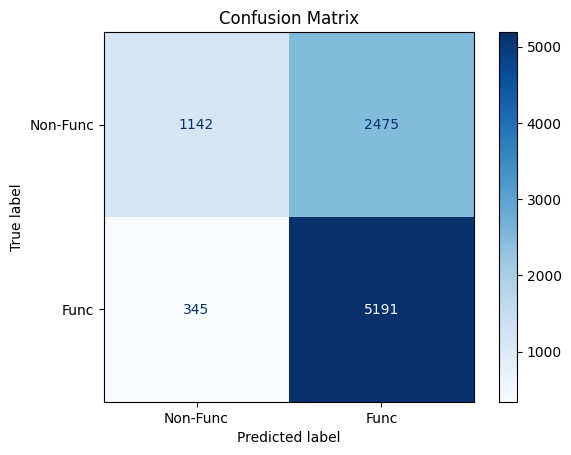

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.77      0.32      0.45      3617
        Func       0.68      0.94      0.79      5536

    accuracy                           0.69      9153
   macro avg       0.72      0.63      0.62      9153
weighted avg       0.71      0.69      0.65      9153

Confusion Matrix for Validation
8/8 [==============================] - 0s 2ms/step
92 141 233


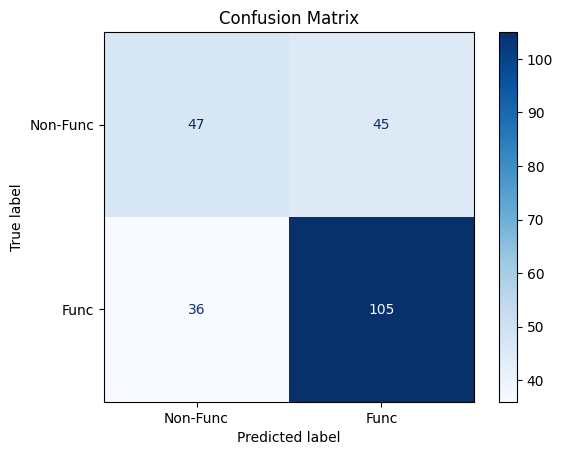

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.57      0.51      0.54        92
        Func       0.70      0.74      0.72       141

    accuracy                           0.65       233
   macro avg       0.63      0.63      0.63       233
weighted avg       0.65      0.65      0.65       233



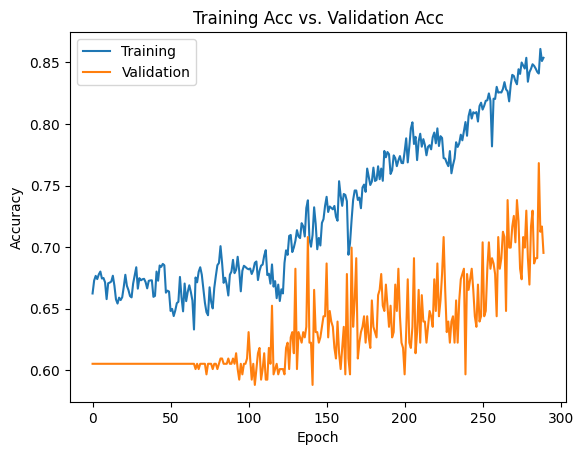

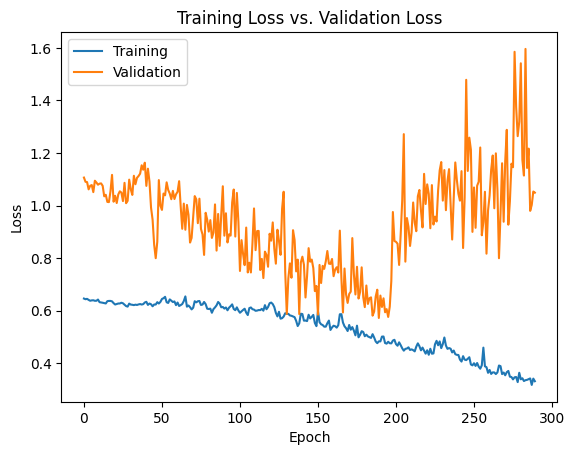

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 136 138
 139 140 141]
Z val:  [133]
Train:  3644 5547
Val:  65 130
class weights:  [1.26111416 0.82846584]
Epoch 1/5000
144/144 - 4s - loss: 0.6360 - binary_accuracy: 0.6820 - f1_m: 0.5901 - val_loss: 0.7740 - val_binary_accuracy: 0.6667 - val_f1_m: 0.6044 - lr: 0.0010 - 4s/epoch - 29ms/step
Epoch 2/5000
144/144 - 1s - loss: 0.6426 - binary_accuracy: 0.6802 - f1_m: 0.5882 - val_loss: 0.7871 - val_binary_accuracy: 0.6667 - val_f1_m: 0.6044 - lr: 0.0010 - 808ms/epoch - 6ms/step
Epoch 3/5000
144/144 - 1s - loss: 0.6346 - binary_accuracy: 0.6828 - f1_m: 0.5870 - val_loss: 0.7878 - val_binary_accuracy: 0.6667 - val_f1_m: 0.6044 - lr: 0.0010 - 822ms/epoch - 6ms/step
Epoch 4/5000
144/144 - 1s - loss: 0.6354 - binary_accuracy: 0.6828 - f1_m: 0.5775 - val_loss: 0.8074 - val_binary_accuracy: 0.6667 - val_f1_m: 0.6044 - lr: 0.0010 - 784ms/epoch - 5ms/step
Epoch 5/5000
144/144 - 1s - loss: 0.6335 - binary_accuracy: 0.6733 -

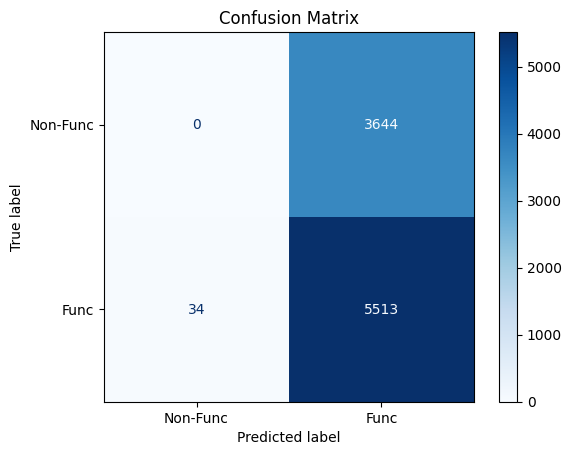

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3644
        Func       0.60      0.99      0.75      5547

    accuracy                           0.60      9191
   macro avg       0.30      0.50      0.37      9191
weighted avg       0.36      0.60      0.45      9191

Confusion Matrix for Validation
7/7 [==============================] - 0s 3ms/step
65 130 195


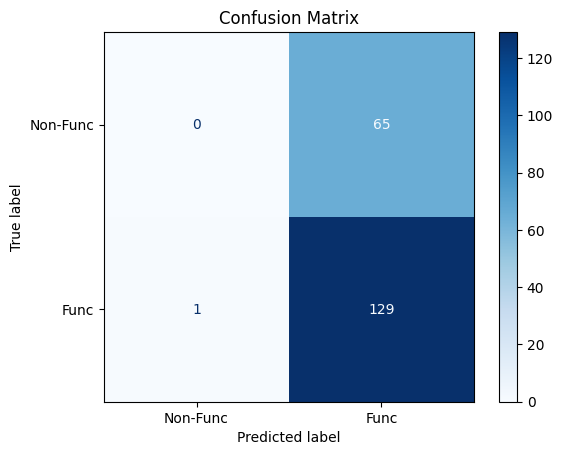

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00        65
        Func       0.66      0.99      0.80       130

    accuracy                           0.66       195
   macro avg       0.33      0.50      0.40       195
weighted avg       0.44      0.66      0.53       195



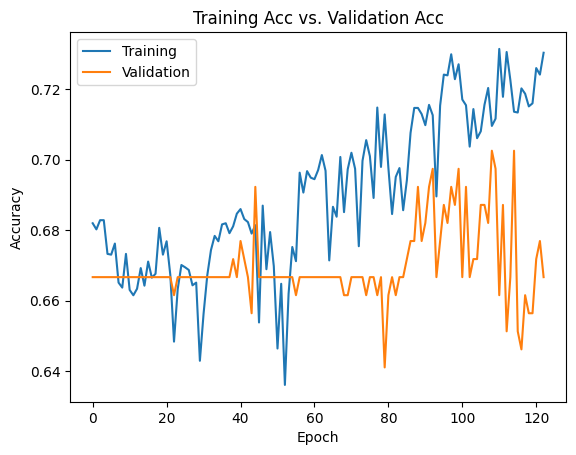

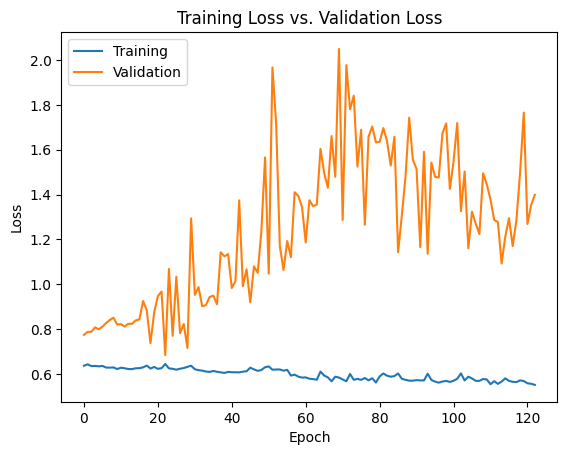

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136
 138 139 140]
Z val:  [141]
Train:  3597 5594
Val:  112 83
class weights:  [1.27759244 0.82150518]
Epoch 1/5000
144/144 - 5s - loss: 0.6401 - binary_accuracy: 0.6820 - f1_m: 0.5888 - val_loss: 1.2120 - val_binary_accuracy: 0.4256 - val_f1_m: 0.4505 - lr: 0.0010 - 5s/epoch - 33ms/step
Epoch 2/5000
144/144 - 1s - loss: 0.6315 - binary_accuracy: 0.6828 - f1_m: 0.5838 - val_loss: 1.2172 - val_binary_accuracy: 0.4256 - val_f1_m: 0.4505 - lr: 0.0010 - 838ms/epoch - 6ms/step
Epoch 3/5000
144/144 - 1s - loss: 0.6344 - binary_accuracy: 0.6814 - f1_m: 0.5891 - val_loss: 1.2074 - val_binary_accuracy: 0.4256 - val_f1_m: 0.4505 - lr: 0.0010 - 858ms/epoch - 6ms/step
Epoch 4/5000
144/144 - 1s - loss: 0.6357 - binary_accuracy: 0.6850 - f1_m: 0.5748 - val_loss: 1.1850 - val_binary_accuracy: 0.4256 - val_f1_m: 0.4505 - lr: 0.0010 - 868ms/epoch - 6ms/step
Epoch 5/5000
144/144 - 1s - loss: 0.6342 - binary_accuracy: 0.6840 -

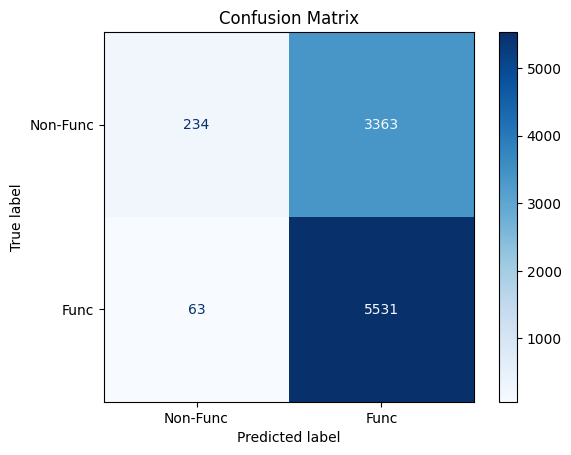

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.79      0.07      0.12      3597
        Func       0.62      0.99      0.76      5594

    accuracy                           0.63      9191
   macro avg       0.70      0.53      0.44      9191
weighted avg       0.69      0.63      0.51      9191

Confusion Matrix for Validation
7/7 [==============================] - 0s 2ms/step
112 83 195


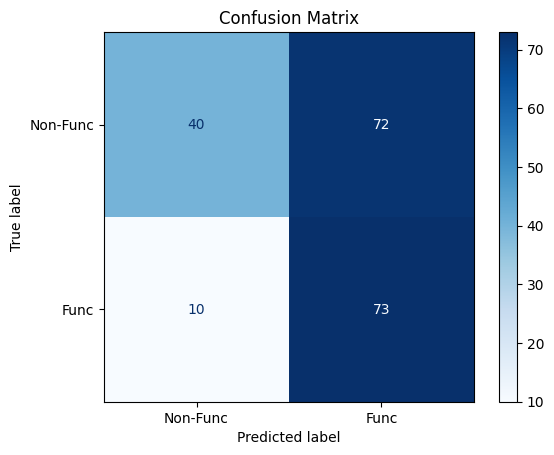

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.80      0.36      0.49       112
        Func       0.50      0.88      0.64        83

    accuracy                           0.58       195
   macro avg       0.65      0.62      0.57       195
weighted avg       0.67      0.58      0.56       195



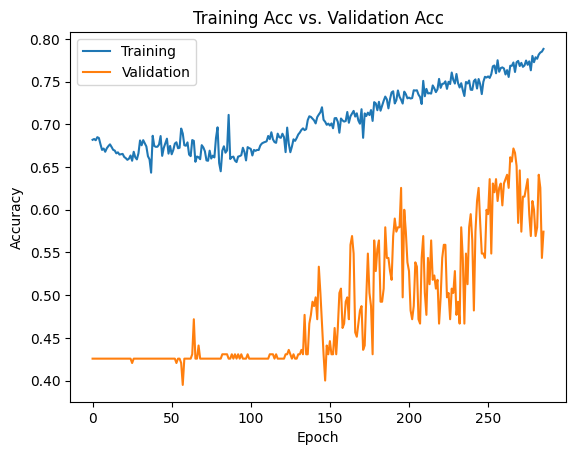

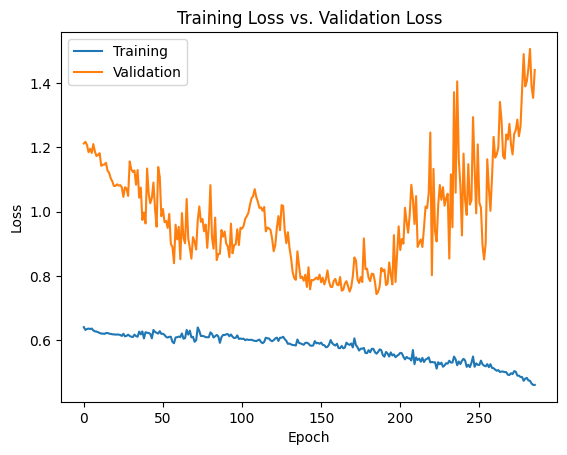

Z train:  [104 105 106 107 108 109 116 118 119 121 122 125 126 129 132 133 136 138
 139 140 141]
Z val:  [114]
Train:  3544 5659
Val:  165 18
class weights:  [1.29839165 0.81312953]
Epoch 1/5000
144/144 - 4s - loss: 0.6390 - binary_accuracy: 0.6729 - f1_m: 0.6081 - val_loss: 2.0979 - val_binary_accuracy: 0.0984 - val_f1_m: 0.1729 - lr: 0.0010 - 4s/epoch - 27ms/step
Epoch 2/5000
144/144 - 1s - loss: 0.6378 - binary_accuracy: 0.6615 - f1_m: 0.6001 - val_loss: 2.0914 - val_binary_accuracy: 0.0984 - val_f1_m: 0.1729 - lr: 0.0010 - 843ms/epoch - 6ms/step
Epoch 3/5000
144/144 - 1s - loss: 0.6306 - binary_accuracy: 0.6749 - f1_m: 0.5967 - val_loss: 2.0715 - val_binary_accuracy: 0.0984 - val_f1_m: 0.1729 - lr: 0.0010 - 959ms/epoch - 7ms/step
Epoch 4/5000
144/144 - 1s - loss: 0.6379 - binary_accuracy: 0.6680 - f1_m: 0.5996 - val_loss: 2.0771 - val_binary_accuracy: 0.0984 - val_f1_m: 0.1729 - lr: 0.0010 - 980ms/epoch - 7ms/step
Epoch 5/5000
144/144 - 1s - loss: 0.6298 - binary_accuracy: 0.6650 -

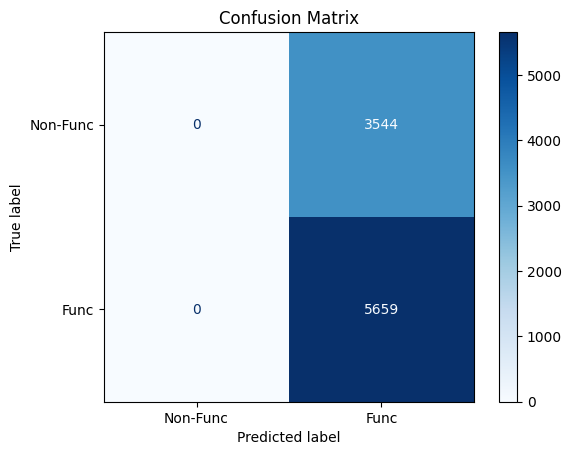

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3544
        Func       0.61      1.00      0.76      5659

    accuracy                           0.61      9203
   macro avg       0.31      0.50      0.38      9203
weighted avg       0.38      0.61      0.47      9203

Confusion Matrix for Validation
6/6 [==============================] - 0s 2ms/step
165 18 183


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


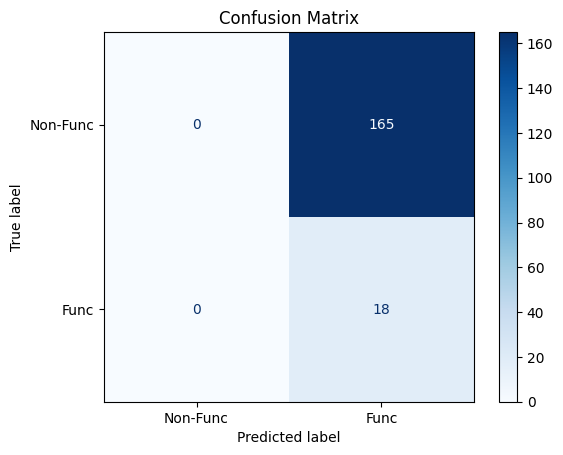

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00       165
        Func       0.10      1.00      0.18        18

    accuracy                           0.10       183
   macro avg       0.05      0.50      0.09       183
weighted avg       0.01      0.10      0.02       183



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


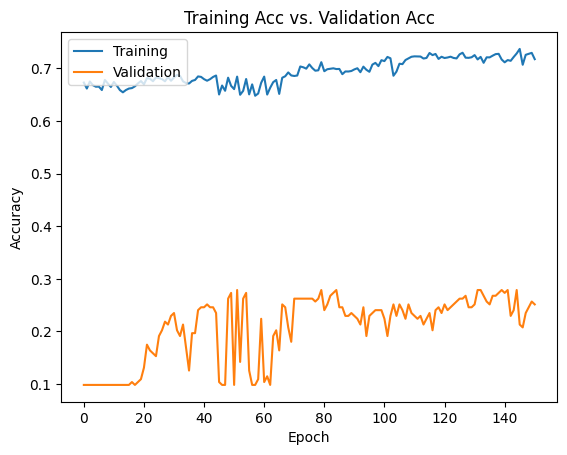

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136
 139 140 141]
Z val:  [138]
Train:  3642 5584
Val:  67 93
class weights:  [1.26661175 0.82611032]
Epoch 1/5000
145/145 - 4s - loss: 0.6432 - binary_accuracy: 0.6745 - f1_m: 0.5627 - val_loss: 1.2028 - val_binary_accuracy: 0.5813 - val_f1_m: 0.7407 - lr: 0.0010 - 4s/epoch - 27ms/step
Epoch 2/5000
145/145 - 1s - loss: 0.6416 - binary_accuracy: 0.6710 - f1_m: 0.5734 - val_loss: 1.2670 - val_binary_accuracy: 0.5813 - val_f1_m: 0.7407 - lr: 0.0010 - 810ms/epoch - 6ms/step
Epoch 3/5000
145/145 - 1s - loss: 0.6407 - binary_accuracy: 0.6728 - f1_m: 0.5650 - val_loss: 1.2759 - val_binary_accuracy: 0.5813 - val_f1_m: 0.7407 - lr: 0.0010 - 803ms/epoch - 6ms/step
Epoch 4/5000
145/145 - 1s - loss: 0.6429 - binary_accuracy: 0.6704 - f1_m: 0.5921 - val_loss: 1.2765 - val_binary_accuracy: 0.5813 - val_f1_m: 0.7407 - lr: 0.0010 - 842ms/epoch - 6ms/step
Epoch 5/5000
145/145 - 1s - loss: 0.6352 - binary_accuracy: 0.6774 - 

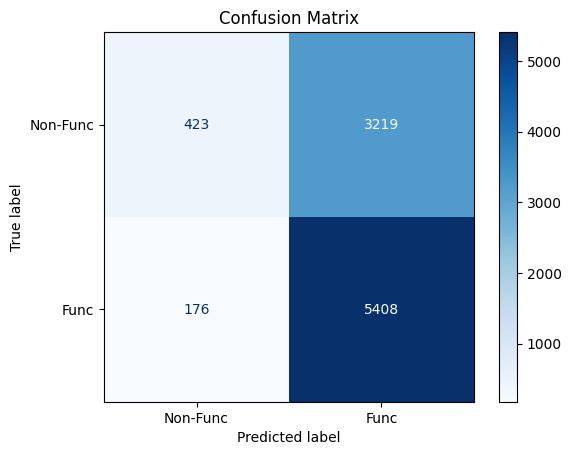

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.71      0.12      0.20      3642
        Func       0.63      0.97      0.76      5584

    accuracy                           0.63      9226
   macro avg       0.67      0.54      0.48      9226
weighted avg       0.66      0.63      0.54      9226

Confusion Matrix for Validation
5/5 [==============================] - 0s 4ms/step
67 93 160


Classification Report
              precision    recall  f1-score   support

    Non-Func       0.33      0.01      0.03        67
        Func       0.58      0.98      0.73        93

    accuracy                           0.57       160
   macro avg       0.46      0.50      0.38       160
weighted avg       0.48      0.57      0.44       160



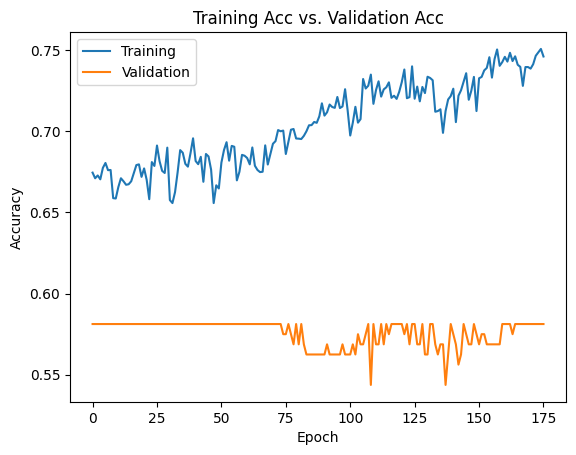

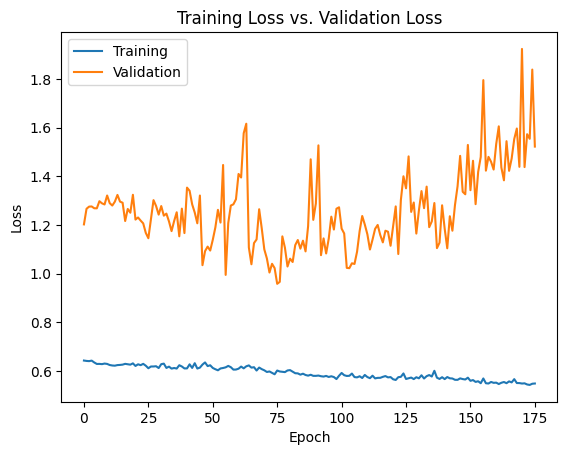

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 132 133 136 138
 139 140 141]
Z val:  [129]
Train:  3663 5586
Val:  46 91
class weights:  [1.26248976 0.82787325]
Epoch 1/5000
145/145 - 6s - loss: 0.6425 - binary_accuracy: 0.6683 - f1_m: 0.5620 - val_loss: 0.7625 - val_binary_accuracy: 0.6642 - val_f1_m: 0.8528 - lr: 0.0010 - 6s/epoch - 42ms/step
Epoch 2/5000
145/145 - 1s - loss: 0.6406 - binary_accuracy: 0.6748 - f1_m: 0.5827 - val_loss: 0.7761 - val_binary_accuracy: 0.6642 - val_f1_m: 0.8528 - lr: 0.0010 - 728ms/epoch - 5ms/step
Epoch 3/5000
145/145 - 1s - loss: 0.6410 - binary_accuracy: 0.6702 - f1_m: 0.5604 - val_loss: 0.7641 - val_binary_accuracy: 0.6642 - val_f1_m: 0.8528 - lr: 0.0010 - 760ms/epoch - 5ms/step
Epoch 4/5000
145/145 - 1s - loss: 0.6408 - binary_accuracy: 0.6716 - f1_m: 0.5748 - val_loss: 0.7739 - val_binary_accuracy: 0.6642 - val_f1_m: 0.8528 - lr: 0.0010 - 796ms/epoch - 5ms/step
Epoch 5/5000
145/145 - 1s - loss: 0.6445 - binary_accuracy: 0.6668 - 

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3663
        Func       0.60      1.00      0.75      5586

    accuracy                           0.60      9249
   macro avg       0.30      0.50      0.38      9249
weighted avg       0.36      0.60      0.45      9249

Confusion Matrix for Validation
5/5 [==============================] - 0s 2ms/step
46 91 137


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00        46
        Func       0.66      1.00      0.80        91

    accuracy                           0.66       137
   macro avg       0.33      0.50      0.40       137
weighted avg       0.44      0.66      0.53       137



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


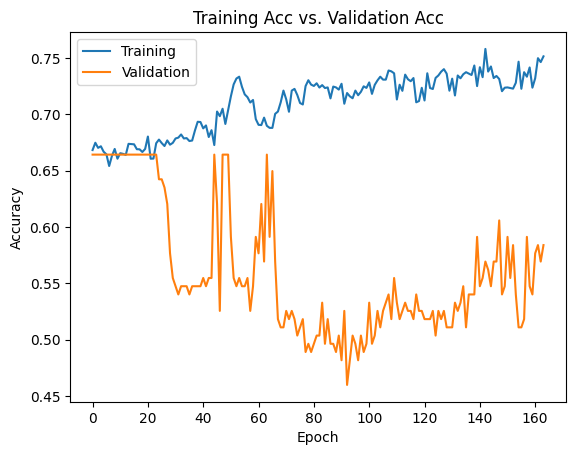

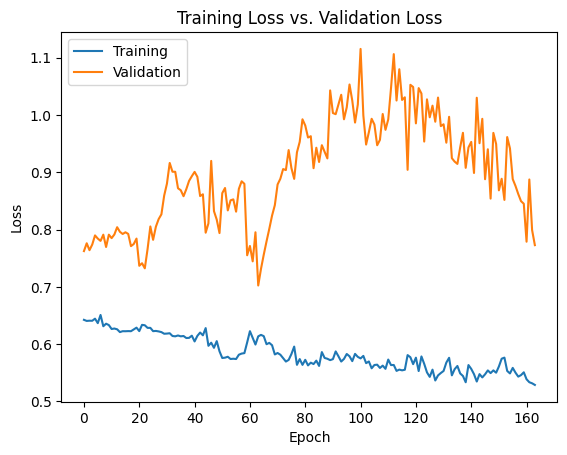

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 136
 138 139 141]
Z val:  [140]
Train:  3679 5602
Val:  30 75
class weights:  [1.26134819 0.82836487]
Epoch 1/5000
146/146 - 4s - loss: 0.6361 - binary_accuracy: 0.6825 - f1_m: 0.5726 - val_loss: 0.9256 - val_binary_accuracy: 0.7143 - val_f1_m: 0.7963 - lr: 0.0010 - 4s/epoch - 28ms/step
Epoch 2/5000
146/146 - 1s - loss: 0.6360 - binary_accuracy: 0.6776 - f1_m: 0.5785 - val_loss: 0.9249 - val_binary_accuracy: 0.7143 - val_f1_m: 0.7963 - lr: 0.0010 - 788ms/epoch - 5ms/step
Epoch 3/5000
146/146 - 1s - loss: 0.6381 - binary_accuracy: 0.6661 - f1_m: 0.5929 - val_loss: 0.9103 - val_binary_accuracy: 0.7143 - val_f1_m: 0.7963 - lr: 0.0010 - 788ms/epoch - 5ms/step
Epoch 4/5000
146/146 - 1s - loss: 0.6368 - binary_accuracy: 0.6758 - f1_m: 0.5752 - val_loss: 0.8577 - val_binary_accuracy: 0.7143 - val_f1_m: 0.7963 - lr: 0.0010 - 781ms/epoch - 5ms/step
Epoch 5/5000
146/146 - 1s - loss: 0.6353 - binary_accuracy: 0.6722 - 

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00      3679
        Func       0.60      1.00      0.75      5602

    accuracy                           0.60      9281
   macro avg       0.30      0.50      0.38      9281
weighted avg       0.36      0.60      0.45      9281

Confusion Matrix for Validation
4/4 [==============================] - 0s 2ms/step
30 75 105


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report
              precision    recall  f1-score   support

    Non-Func       0.00      0.00      0.00        30
        Func       0.71      1.00      0.83        75

    accuracy                           0.71       105
   macro avg       0.36      0.50      0.42       105
weighted avg       0.51      0.71      0.60       105



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


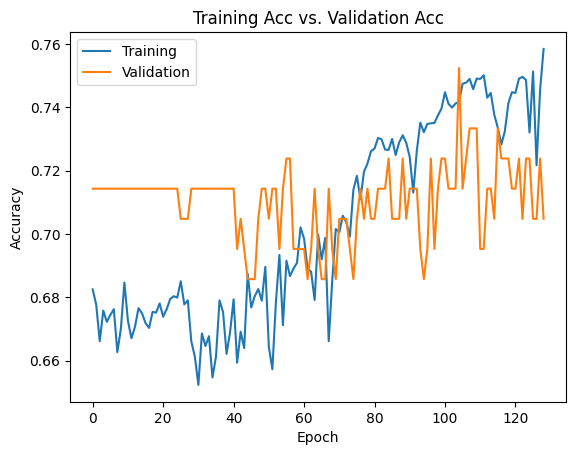

Z train:  [104 105 106 107 108 109 114 116 118 119 121 122 125 126 129 132 133 138
 139 140 141]
Z val:  [136]
Train:  3605 5677
Val:  104 0
class weights:  [1.28737864 0.81750925]
Epoch 1/5000
146/146 - 6s - loss: 0.6335 - binary_accuracy: 0.6826 - f1_m: 0.5905 - val_loss: 2.8760 - val_binary_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - lr: 0.0010 - 6s/epoch - 42ms/step
Epoch 2/5000
146/146 - 1s - loss: 0.6371 - binary_accuracy: 0.6724 - f1_m: 0.5944 - val_loss: 2.8202 - val_binary_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - lr: 0.0010 - 833ms/epoch - 6ms/step
Epoch 3/5000
146/146 - 1s - loss: 0.6311 - binary_accuracy: 0.6838 - f1_m: 0.5957 - val_loss: 2.8507 - val_binary_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - lr: 0.0010 - 881ms/epoch - 6ms/step
Epoch 4/5000
146/146 - 1s - loss: 0.6342 - binary_accuracy: 0.6778 - f1_m: 0.5866 - val_loss: 2.8167 - val_binary_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - lr: 0.0010 - 735ms/epoch - 5ms/step
Epoch 5/5000
146/146 - 1s - loss: 0.6

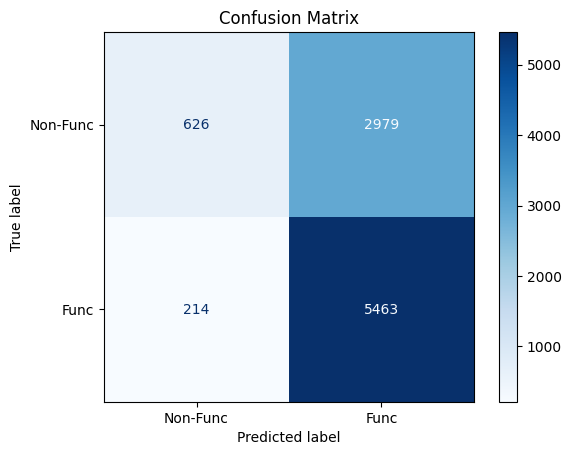

Classification Report
              precision    recall  f1-score   support

    Non-Func       0.75      0.17      0.28      3605
        Func       0.65      0.96      0.77      5677

    accuracy                           0.66      9282
   macro avg       0.70      0.57      0.53      9282
weighted avg       0.69      0.66      0.58      9282

Confusion Matrix for Validation
4/4 [==============================] - 0s 2ms/step
104 0 104


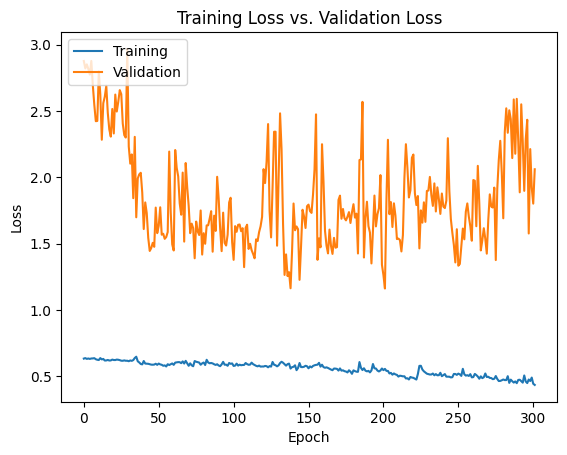

Mean Training Accuracy: 0.6389014775102789
Std Training Accuracy: 0.03775189895122588
Mean Validation Accuracy: 0.6059972488067367
Std Validation Accuracy: 0.24243039331112498


In [12]:
#x = np.load('/notebooks/input/x-60.npy')
#y = np.load('/notebooks/input/y-60.npy')
#z = np.load('/notebooks/input/z-60.npy')
x = np.load('/notebooks/input-30-2s-18-0.6-chronic-0.6-stroke-static-image=True/Chronic_X.npy')
y = np.load('/notebooks/input-30-2s-18-0.6-chronic-0.6-stroke-static-image=True/Chronic_Y.npy')
z = np.load('/notebooks/input-30-2s-18-0.6-chronic-0.6-stroke-static-image=True/Chronic_Z.npy')

print(np.unique(z))
#Left:
indices = np.where(z == 3)[0]
z[indices] = 2
indices = np.where(z == 15)[0]
z[indices] = 14
indices = np.where(z == 27)[0]
z[indices] = 26

#Right:
indices = np.where(z == 5)[0]
z[indices] = 4
indices = np.where(z == 10)[0]
z[indices] = 9
indices = np.where(z == 17)[0]
z[indices] = 16

z[np.isin(z, [0])] = 121
z[np.isin(z, [1])] = 141
z[np.isin(z, [2])] = 105
z[np.isin(z, [4])] = 109
z[np.isin(z, [6])] = 138
z[np.isin(z, [7])] = 133
z[np.isin(z, [8])] = 114
z[np.isin(z, [9])] = 104
z[np.isin(z, [11])] = 132
z[np.isin(z, [12])] = 119
z[np.isin(z, [13])] = 122
z[np.isin(z, [14])] = 107
z[np.isin(z, [16])] = 106
z[np.isin(z, [18])] = 140
z[np.isin(z, [19])] = 116
z[np.isin(z, [20])] = 118
z[np.isin(z, [21])] = 139
z[np.isin(z, [22])] = 126
z[np.isin(z, [23])] = 136
z[np.isin(z, [24])] = 129
z[np.isin(z, [25])] = 125
z[np.isin(z, [26])] = 108
# Find distinct numbers greater than 100
distinct_numbers_greater_than_100 = np.unique(z[z > 100])

# Count the number of distinct numbers greater than 100
count_distinct_greater_than_100 = len(distinct_numbers_greater_than_100)
print(count_distinct_greater_than_100)

#print("X shape:", x.shape)
y = np.array(y)
#print("Y shape:", y.shape)
print(len(y[y == 0]), len(y[y == 1]))
#y = to_categorical(y)

#x = np.reshape(np.transpose(x, axes=(0, 2, 1)), (x.shape[0], x.shape[1]*x.shape[2]))
create_model(x, y, z)



In [ ]:
main_file_path = "/home/tnt/accel/full/"
# Create an empty list to store the data
data = []
# Get a list of all Excel files in a directory
excel_files = sorted(glob.glob("/home/tnt/accel/full/*.xlsx"))

# Loop through each Excel file
for file in excel_files:
    # Read the Excel file and store it in a DataFrame
    df = pd.read_excel(file, header = None, engine='openpyxl')
    # Append the DataFrame to the excel_data list
    data.append(df)
    
x = np.empty((0,duration,3))
y = np.array([])
z = np.array([])
for i in range(0,32):
    
    data[i] = data[i].dropna(axis = 0, how='any', subset=[0,1,2,3])
    data[i] = data[i][(data[i] != 0).all(axis=1)]
    X = data[i][[0, 1, 2]]
    
    Y = data[i][3]
    
    x_temp, y_temp, z_temp = create_data(X, Y, i)
    x = np.append(x, x_temp, axis = 0)
    y = np.append(y, y_temp, axis = 0)
    z = np.append(z, z_temp, axis = 0)
    
    print(i, x.shape, y.shape, z.shape)
np.save(f'/home/tnt/accel/full/etc/x-{duration}.npy', x)
np.save(f'/home/tnt/accel/full/etc/y-{duration}.npy', y)
np.save(f'/home/tnt/accel/full/etc/z-{duration}.npy', z)